<a href="https://colab.research.google.com/github/losttee/Unet_polyp.Segmentation/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving bkai-igh-neopolyp.zip to bkai-igh-neopolyp.zip


In [2]:
import zipfile
import os

with zipfile.ZipFile('bkai-igh-neopolyp.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')


In [3]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=536eef82b720e1eccf8974b9f80657468da7fcfee2fbd08acb7fc7f5bffdf4e2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=d61aa54e53c213e30bbef16a7266565198693e2be3fb834384263f14f1129405
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [4]:
!pip install torchinfo


In [5]:
import os
import pandas as pd
import numpy as np
import cv2
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.transforms import ToTensor
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchinfo import summary
import timm

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
!nvidia-smi

Mon Nov 25 13:23:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.images)

    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, self.resize)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])

        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)

        red_mask = lower_mask + upper_mask;
        red_mask[red_mask != 0] = 1

        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 2

        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = np.expand_dims(full_mask, axis=-1)
        full_mask = full_mask.astype(np.uint8)

        return full_mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = cv2.imread(img_path)  # Đọc ảnh dưới dạng BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert sang RGB
        label = self.read_mask(label_path)
        image = cv2.resize(image, self.resize)
        if self.transform:
            image = self.transform(image)

        return image, label

    def show_image(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = plt.imread(img_path)
        label = plt.imread(label_path)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title('Image')
        axs[1].imshow(label)
        axs[1].set_title('Label')
        plt.show()

In [8]:
image_path = []
TRAIN_DIR = '/content/train/train'
for root, dirs, files in os.walk(TRAIN_DIR):
    for file in files:
        path = os.path.join(root,file)
        image_path.append(path)

len(image_path)

1000

In [9]:
mask_path = []
TRAIN_MASK_DIR = '/content/train_gt/train_gt'
for root, dirs, files in os.walk(TRAIN_MASK_DIR):
    for file in files:
        path = os.path.join(root,file)
        mask_path.append(path)

len(mask_path)

1000

In [10]:
dataset = CustomImageDataset(img_dir= TRAIN_DIR,
                             label_dir= TRAIN_MASK_DIR,
                             resize= (256,256),
                             transform = None)

In [11]:
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 312MB/s]


In [12]:
batch_size = 8
images_data = []
labels_data = []
for x,y in dataset:
    images_data.append(x)
    labels_data.append(y)

In [13]:
class CustomDataset(CustomImageDataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        image = self.data[index]
        label = self.targets[index]
        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed['image'].float()
            label = transformed['mask'].float()
            label = label.permute(2, 0, 1)
        return image, label

    def __len__(self):
        return len(self.data)


train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_size = int(0.9 * len(images_data))
val_size = len(images_data) - train_size
train_dataset = CustomDataset(images_data[:train_size], labels_data[:train_size], transform=train_transform)
val_dataset = CustomDataset(images_data[train_size:], labels_data[train_size:], transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataset))
print(len(val_dataset))

900
100


<ipython-input-13-20a85c7a1ec4>:24: UserWarning: Argument 'eps' is not valid and will be ignored.
  A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),


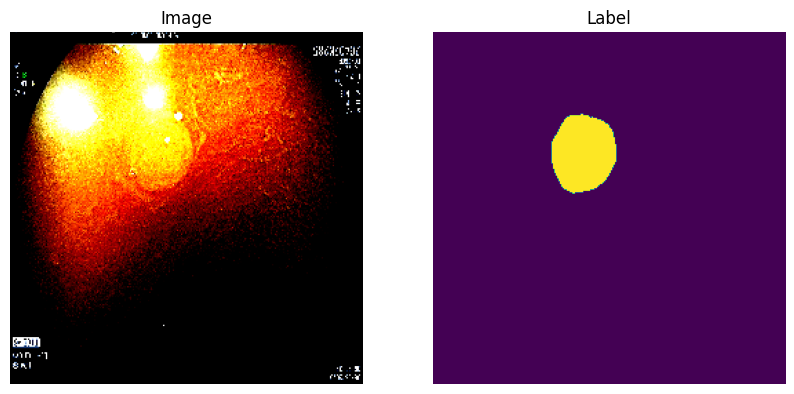

In [14]:
image,label = train_dataset[2]

label_array = label.permute(1, 2, 0).numpy()
image_array = image.permute(1, 2, 0).numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_array)
axs[0].set_title('Image')
axs[0].axis('off')

axs[1].imshow(label_array)
axs[1].set_title('Label')
axs[1].axis('off')

plt.show()

In [15]:
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
color_dict= {0: (0, 0, 0),
             1: (255, 0, 0),
             2: (0, 255, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))

    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)

In [17]:
!pip install wandb
import wandb
!wandb login '649189419e8d316ed2a363d3a3bd2ee4ec494231'

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [18]:
wandb.init(
    project = 'Unet_polyp.Segmentation'
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: duongbui-0310 (duongbui-0310-hanoi-university-of-science-and-technology). Use `wandb login --relogin` to force relogin


Epoch [1/180], Loss: 0.3213966626
Save new model


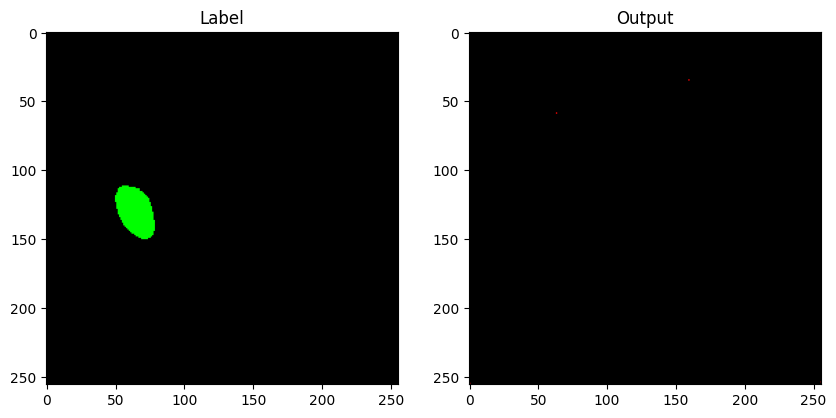

Epoch [2/180], Loss: 0.1743417749
Save new model


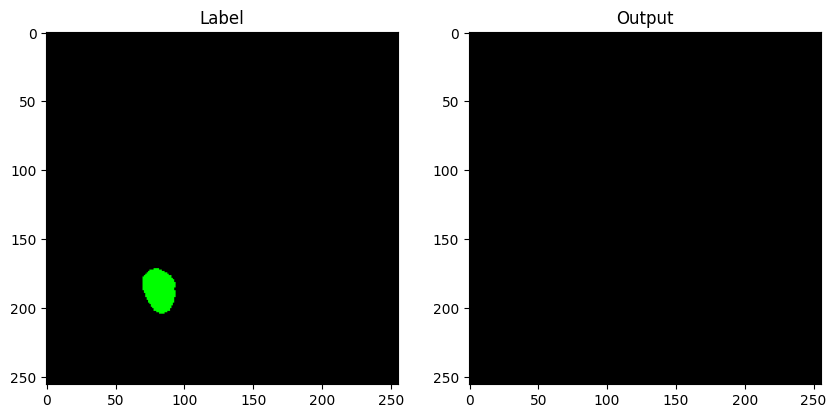

Epoch [3/180], Loss: 0.1248484013
Save new model


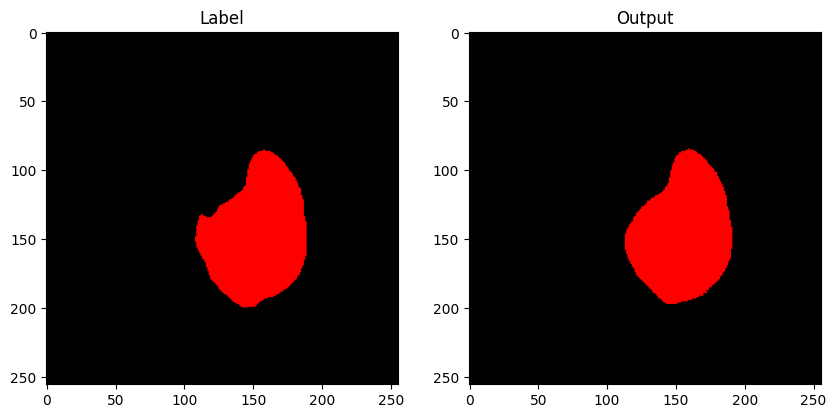

Epoch [4/180], Loss: 0.1117997754
Save new model


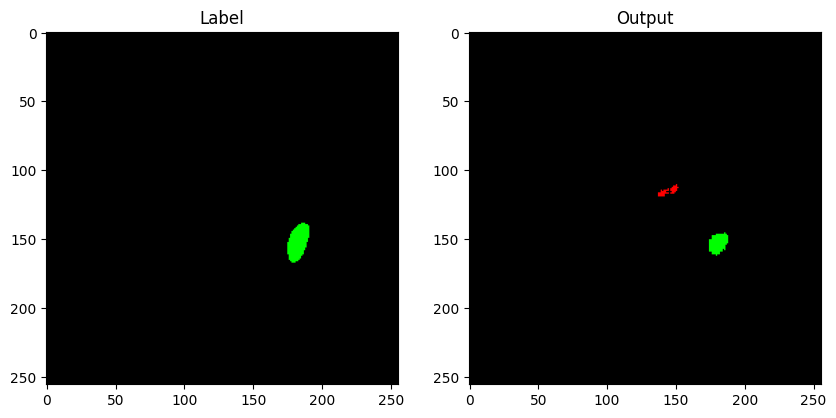

Epoch [5/180], Loss: 0.0999981294
Save new model


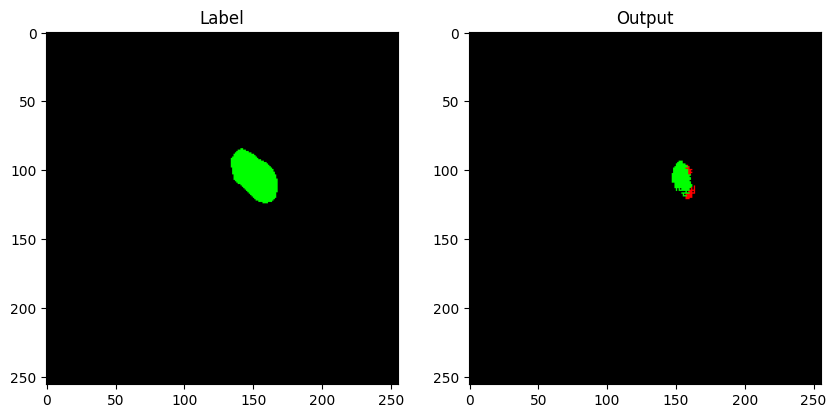

Epoch [6/180], Loss: 0.0935216758
Save new model


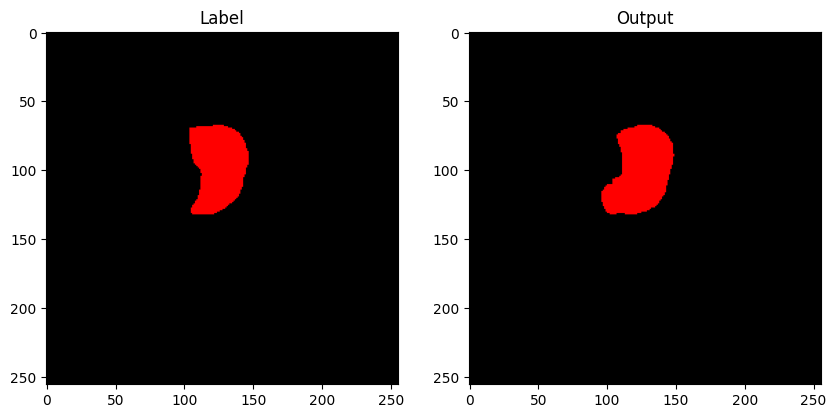

Epoch [7/180], Loss: 0.0834643818
Save new model


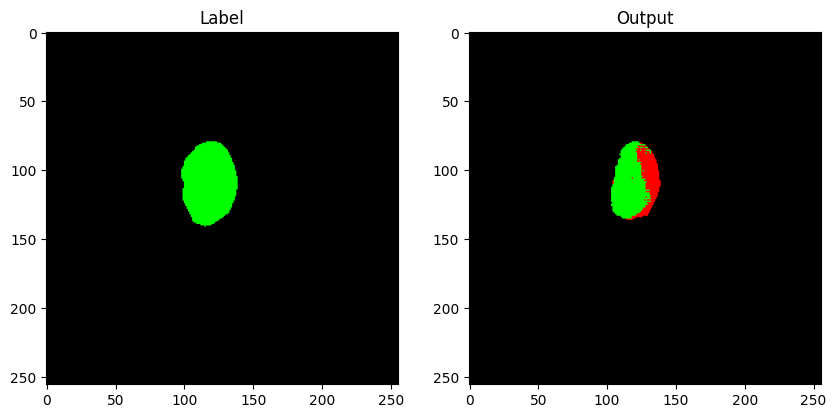

Epoch [8/180], Loss: 0.0854646267


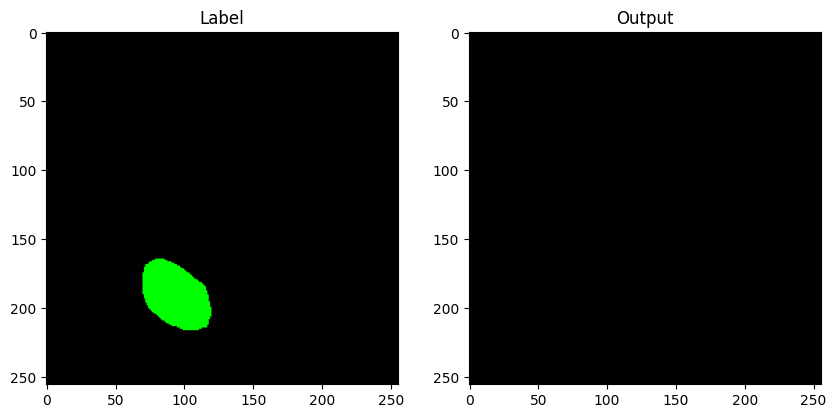

Epoch [9/180], Loss: 0.0873772021


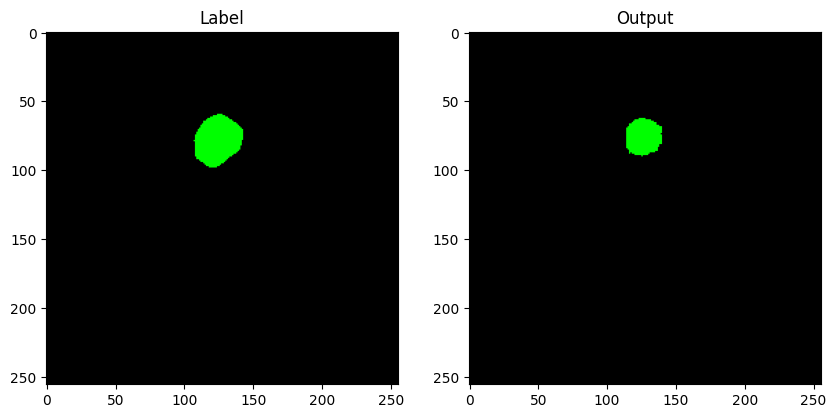

Epoch [10/180], Loss: 0.0841320958


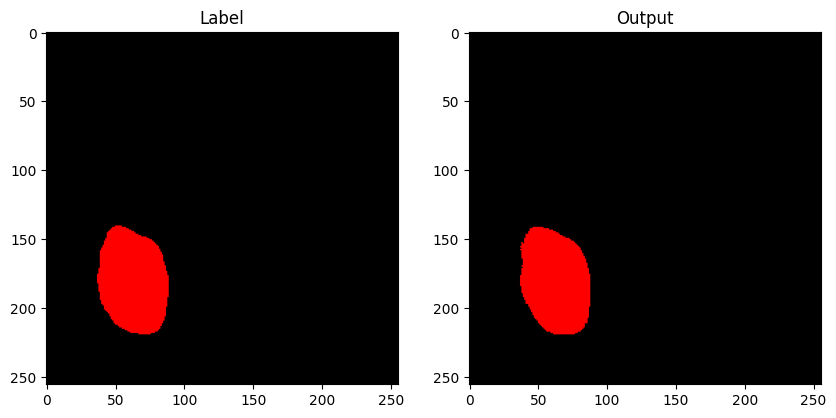

Epoch [11/180], Loss: 0.0829152816
Save new model


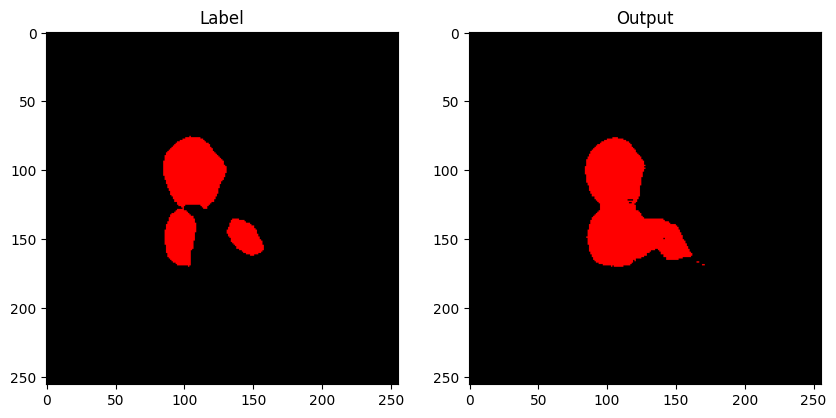

Epoch [12/180], Loss: 0.0781755794
Save new model


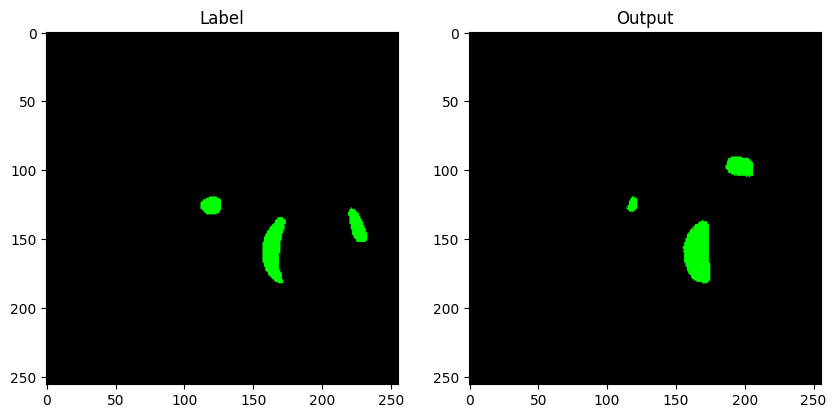

Epoch [13/180], Loss: 0.0811350326


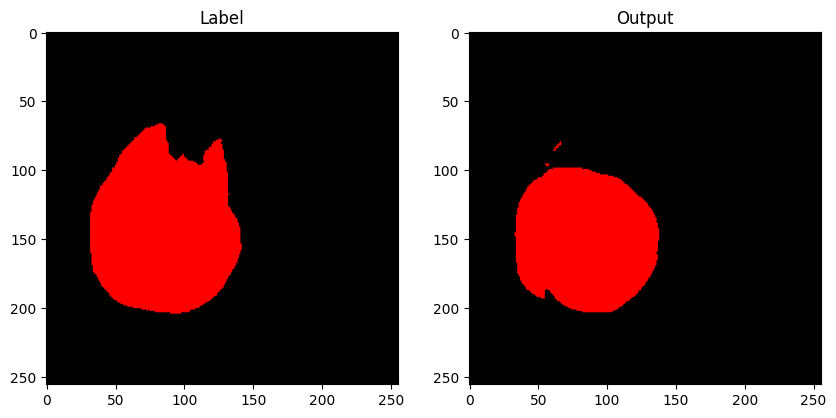

Epoch [14/180], Loss: 0.0765570067
Save new model


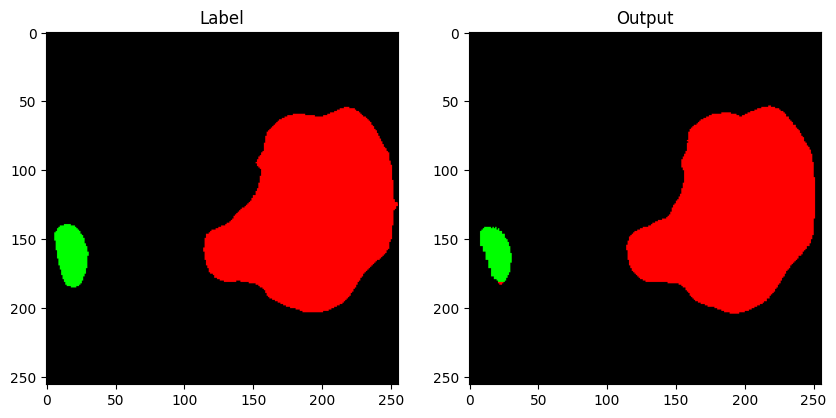

Epoch [15/180], Loss: 0.0806625437


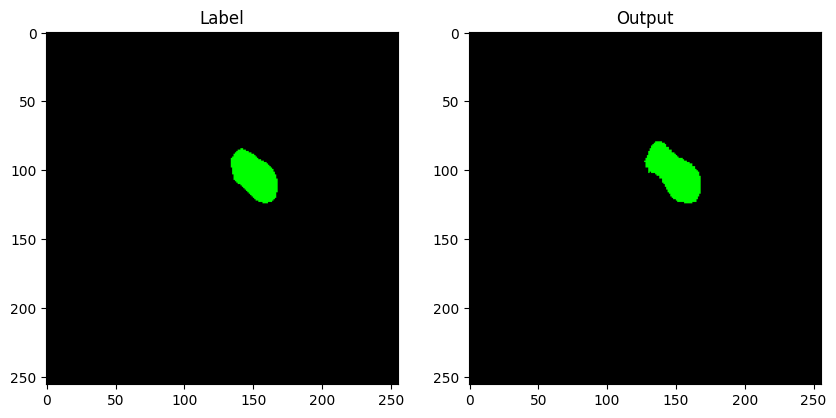

Epoch [16/180], Loss: 0.0834773068


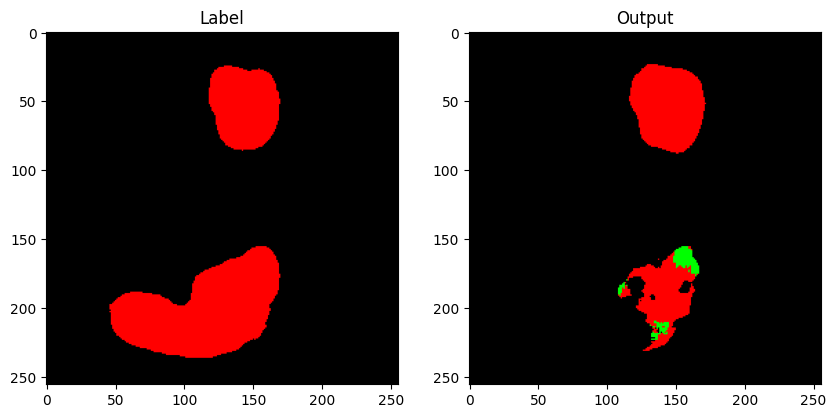

Epoch [17/180], Loss: 0.1118224267


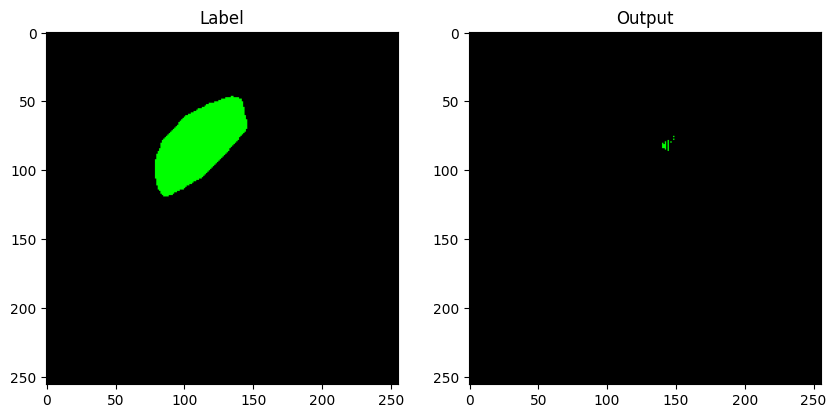

Epoch [18/180], Loss: 0.0740621925
Save new model


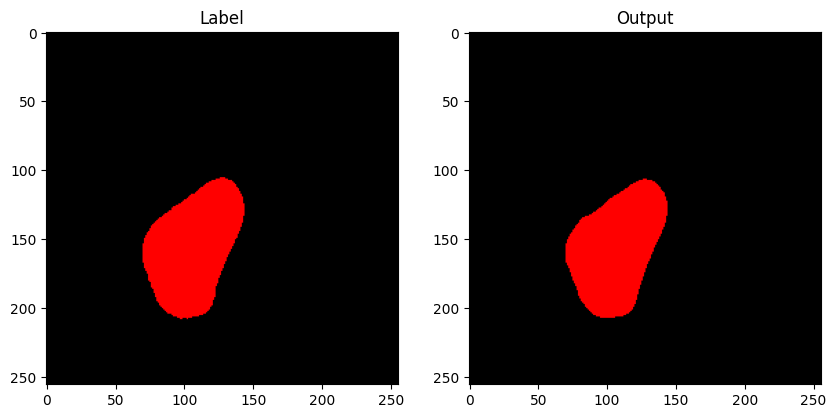

Epoch [19/180], Loss: 0.0737618049
Save new model


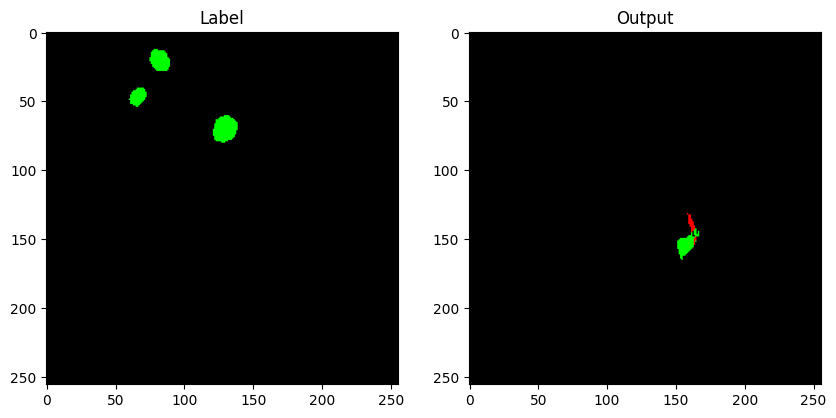

Epoch [20/180], Loss: 0.0829449997


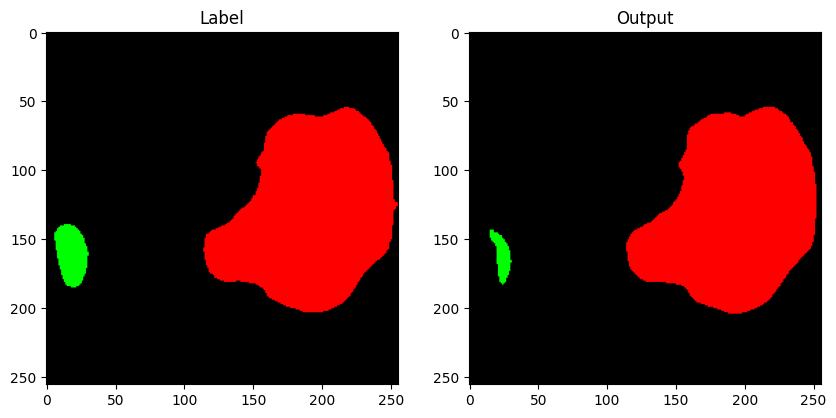

Epoch [21/180], Loss: 0.0987256581


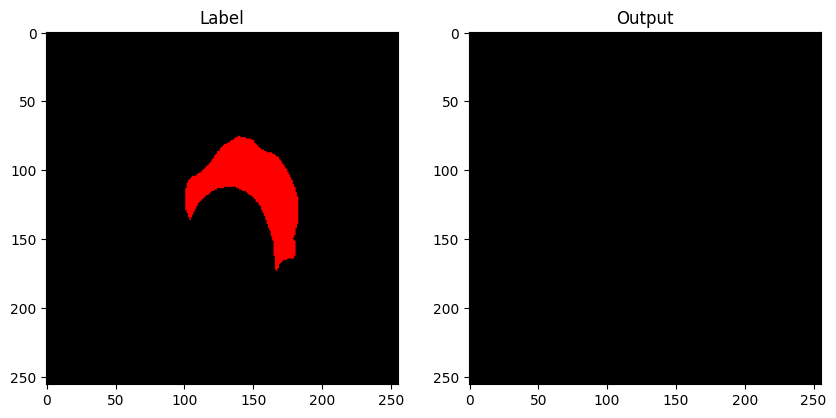

Epoch [22/180], Loss: 0.0808124423


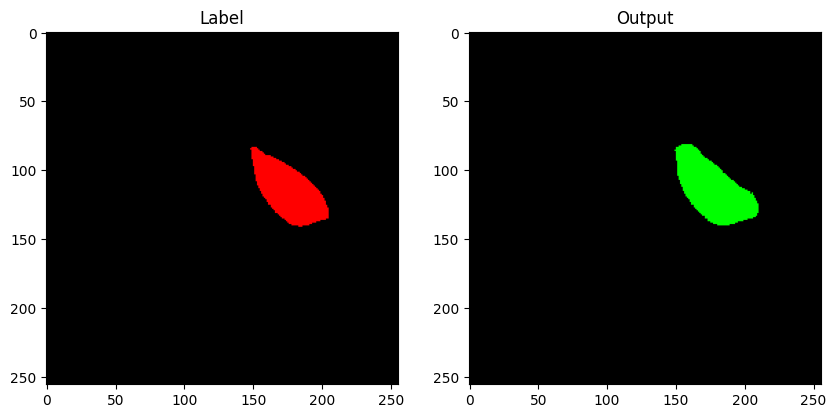

Epoch [23/180], Loss: 0.0878293622


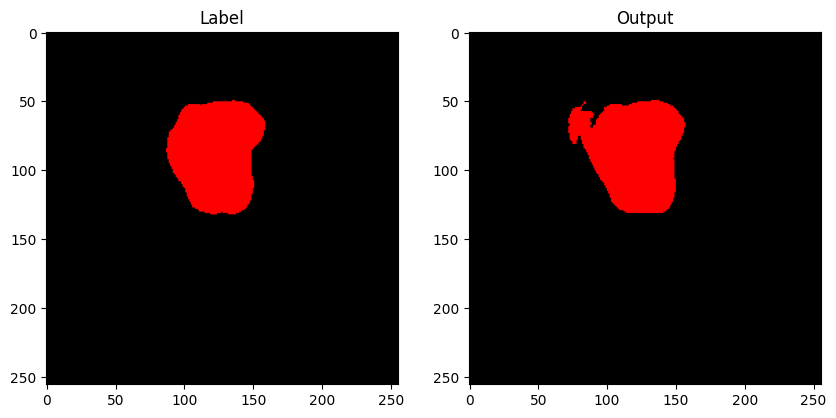

Epoch [24/180], Loss: 0.0810824972


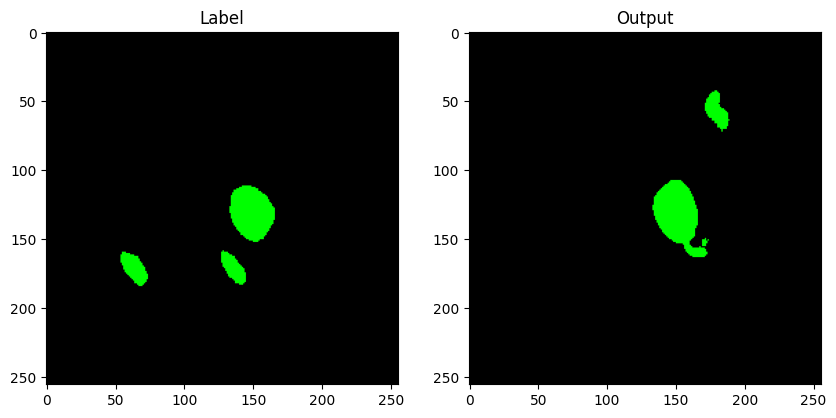

Epoch [25/180], Loss: 0.0886542705


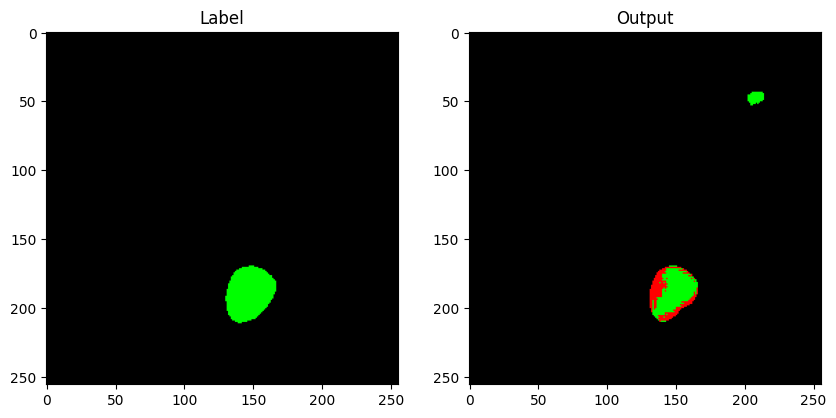

Epoch [26/180], Loss: 0.0985525763


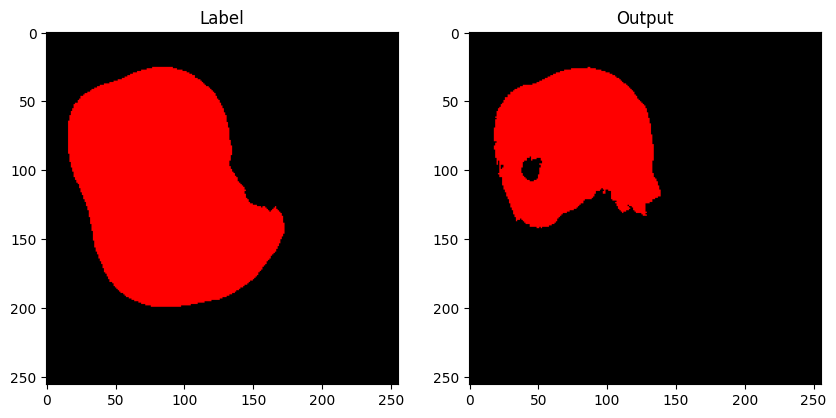

Epoch [27/180], Loss: 0.0896088408


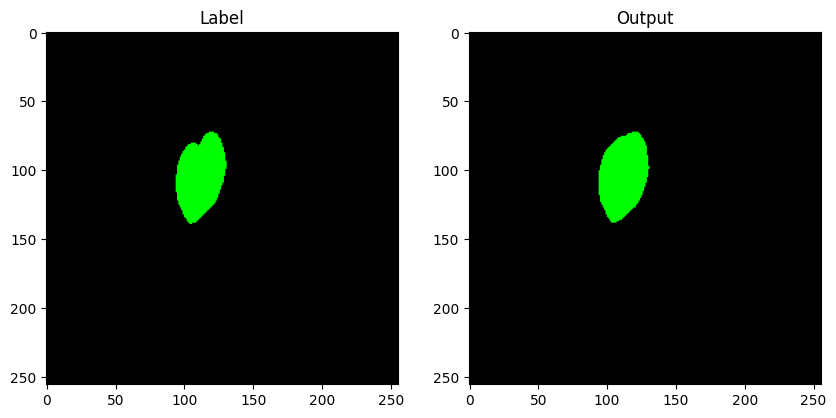

Epoch [28/180], Loss: 0.1001420609


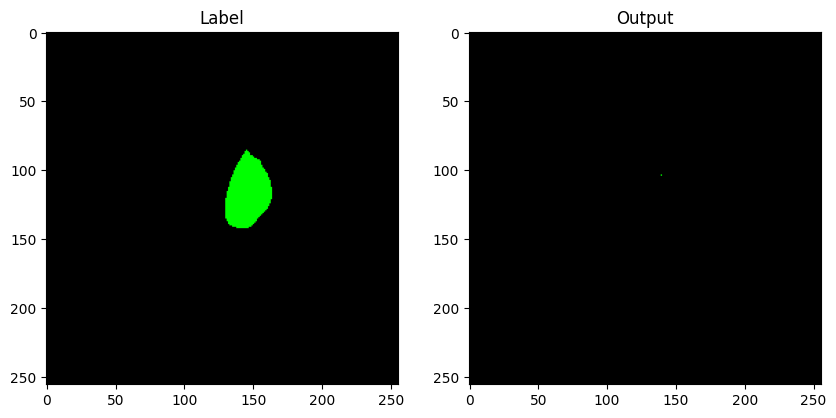

Epoch [29/180], Loss: 0.0998993607


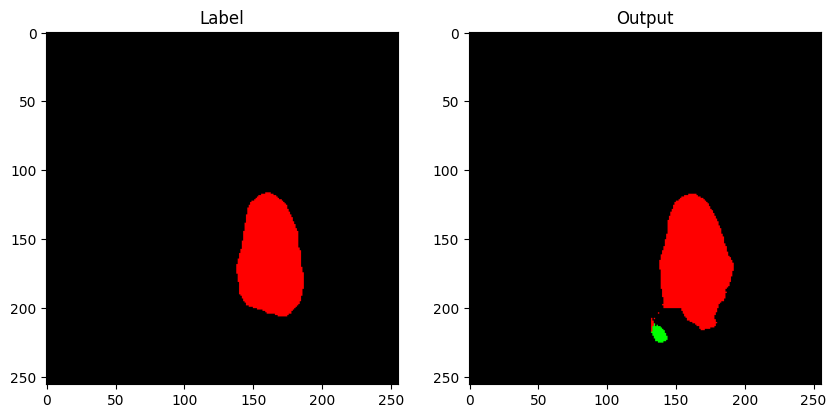

Epoch [30/180], Loss: 0.0879848882


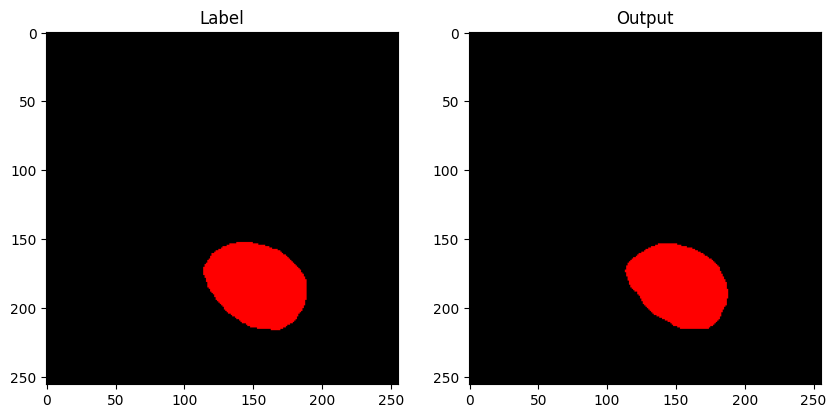

Epoch [31/180], Loss: 0.0889128829


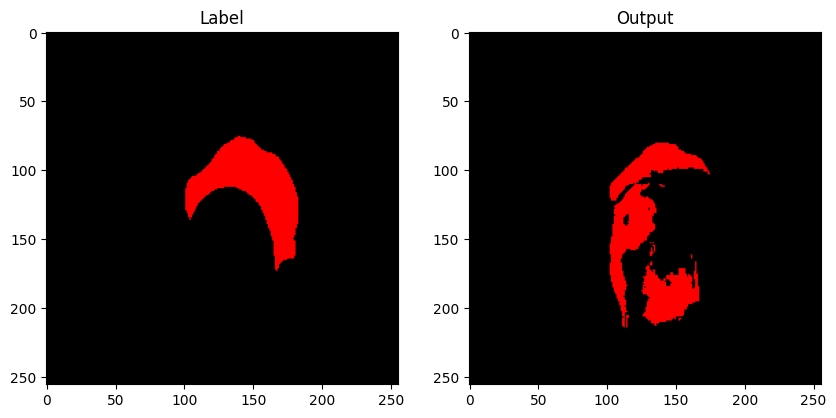

Epoch [32/180], Loss: 0.0869430815


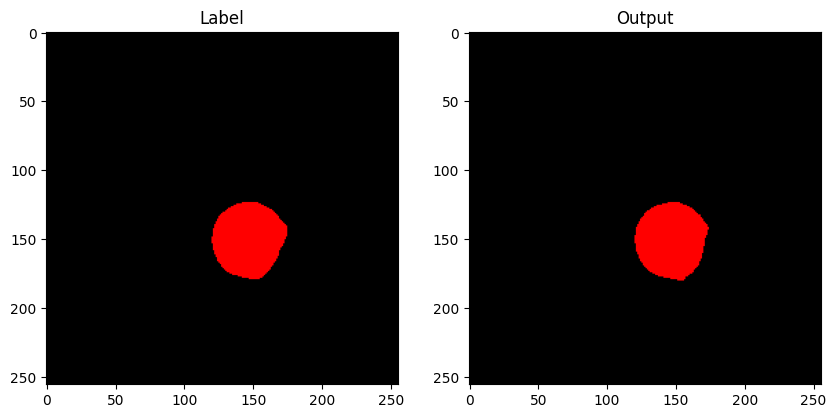

Epoch [33/180], Loss: 0.0873171713


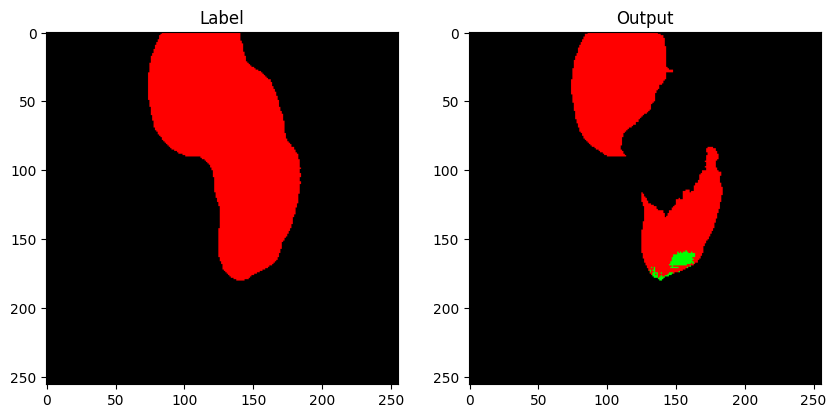

Epoch [34/180], Loss: 0.0836011287


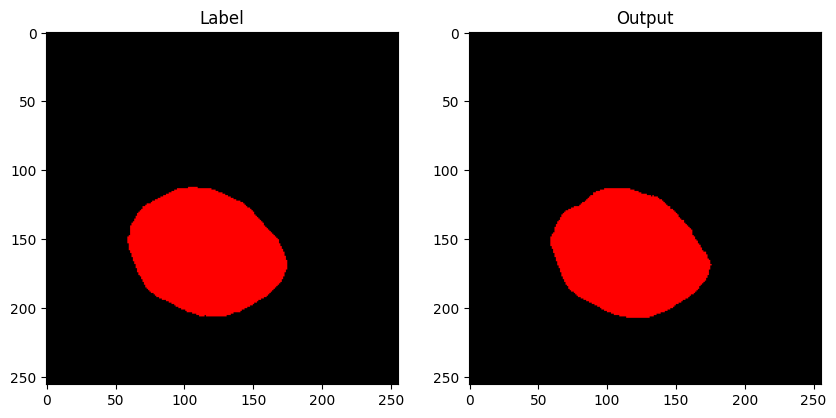

Epoch [35/180], Loss: 0.1176764058


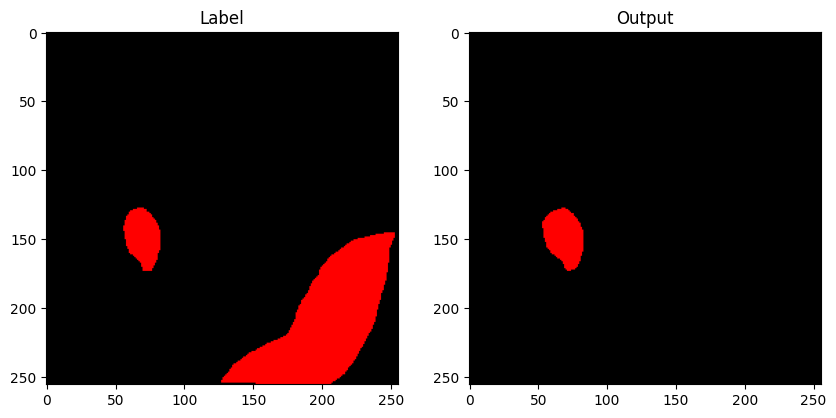

Epoch [36/180], Loss: 0.0829126230


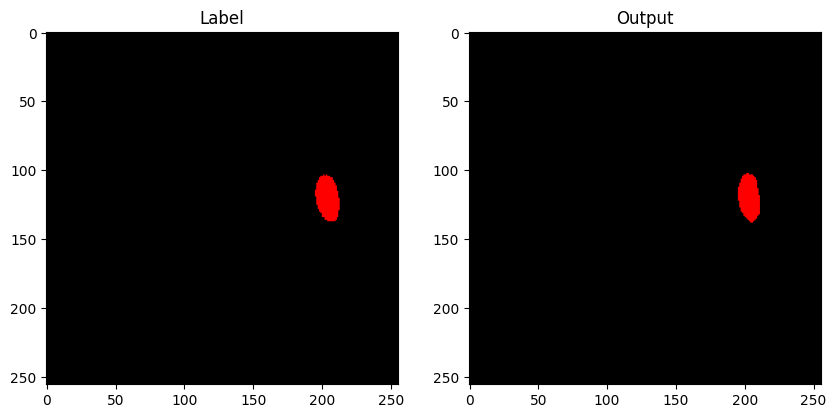

Epoch [37/180], Loss: 0.0887515235


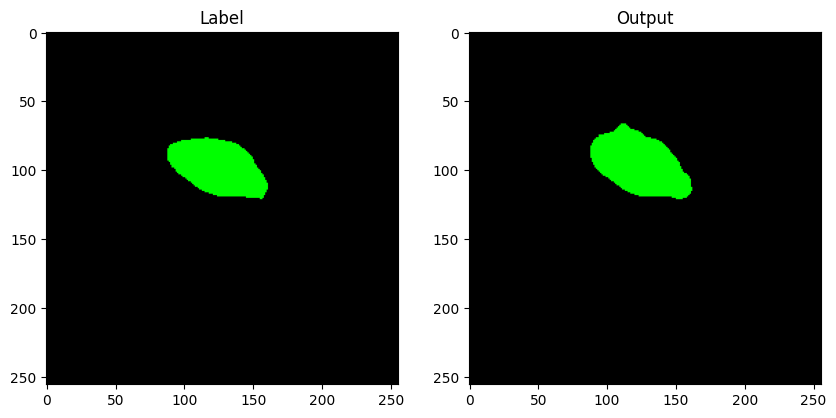

Epoch [38/180], Loss: 0.1141552514


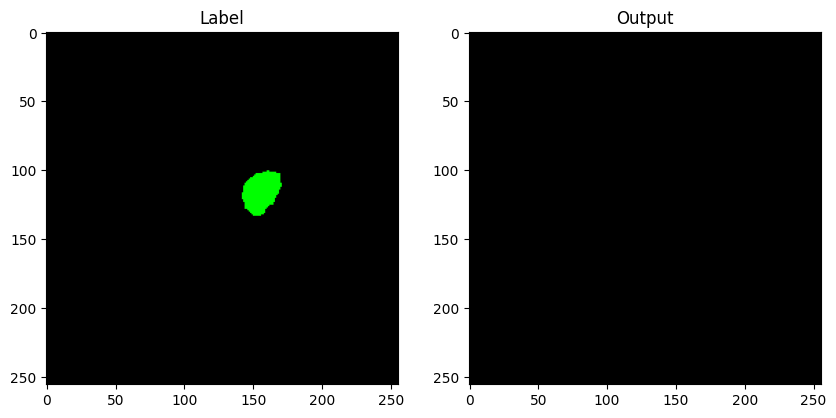

Epoch [39/180], Loss: 0.1124057265


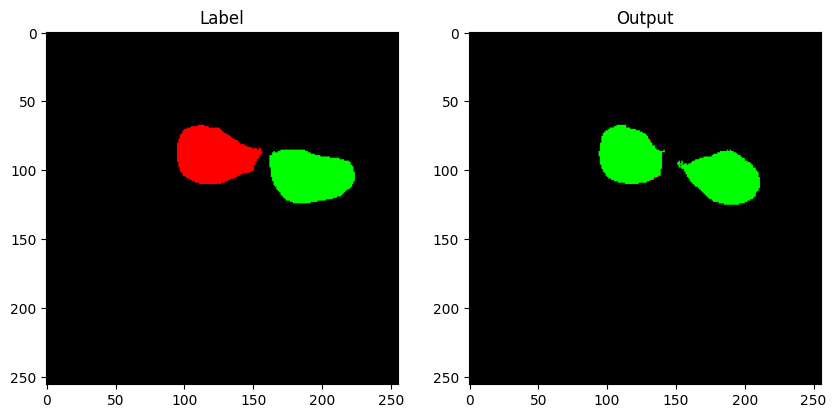

Epoch [40/180], Loss: 0.0905801548


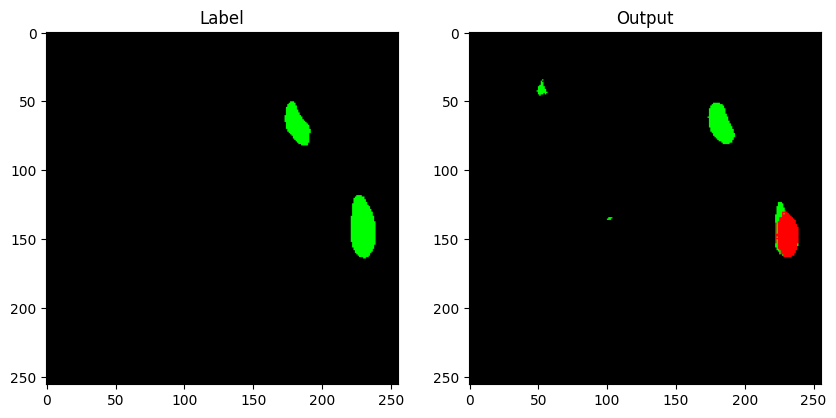

Epoch [41/180], Loss: 0.1072417306


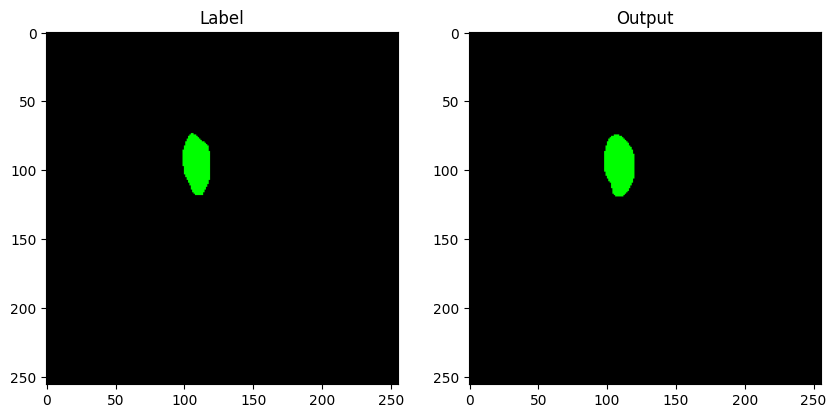

Epoch [42/180], Loss: 0.0914399069


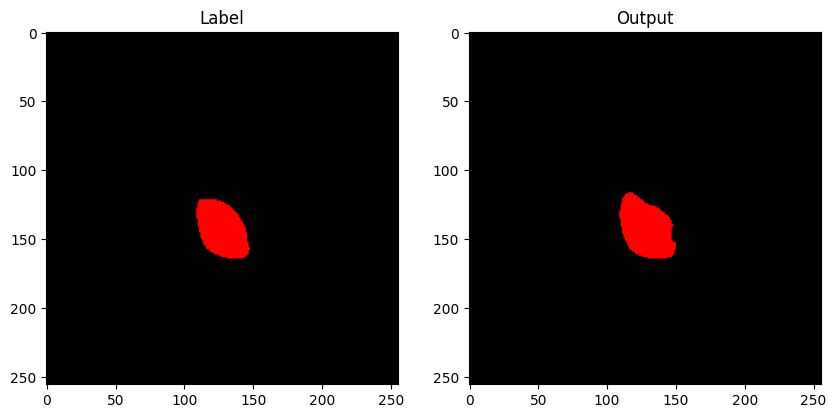

Epoch [43/180], Loss: 0.0945393371


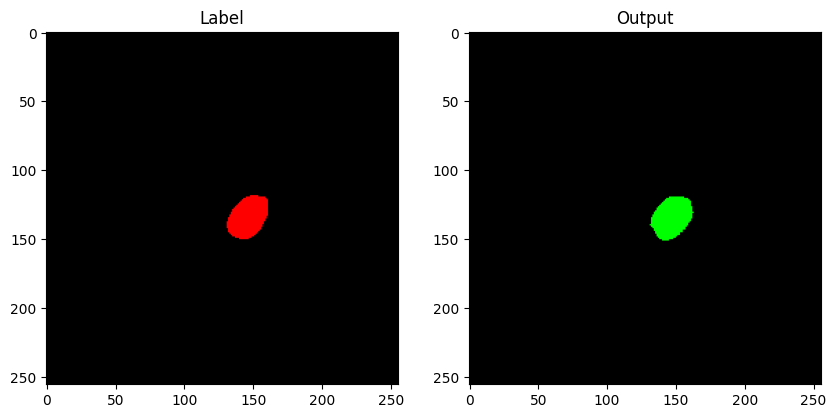

Epoch [44/180], Loss: 0.0912577503


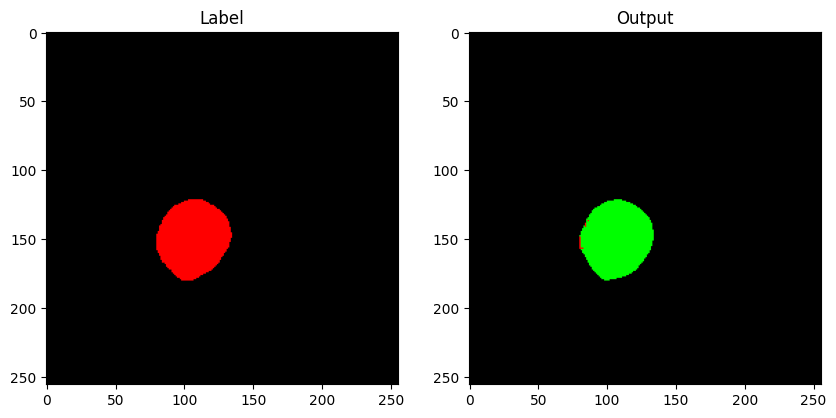

Epoch [45/180], Loss: 0.0817654194


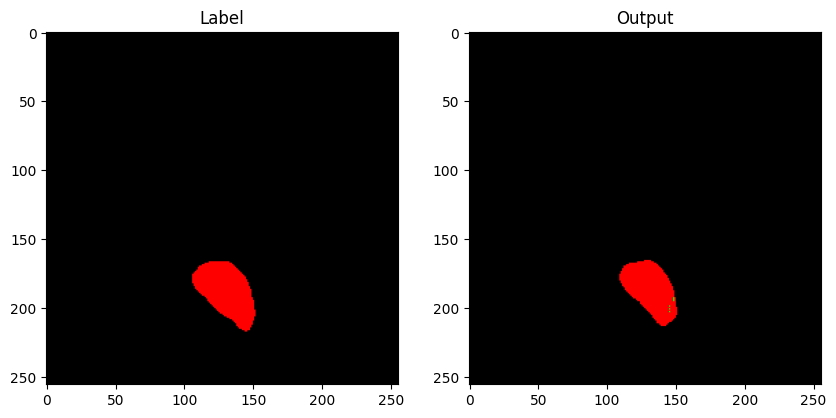

Epoch [46/180], Loss: 0.0823016948


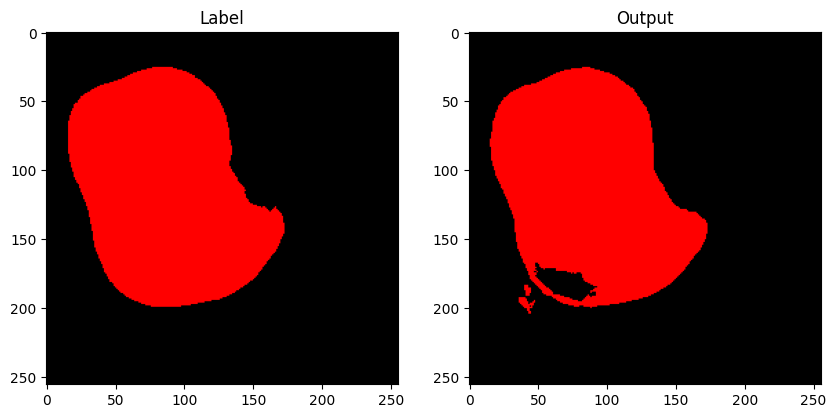

Epoch [47/180], Loss: 0.0975810808


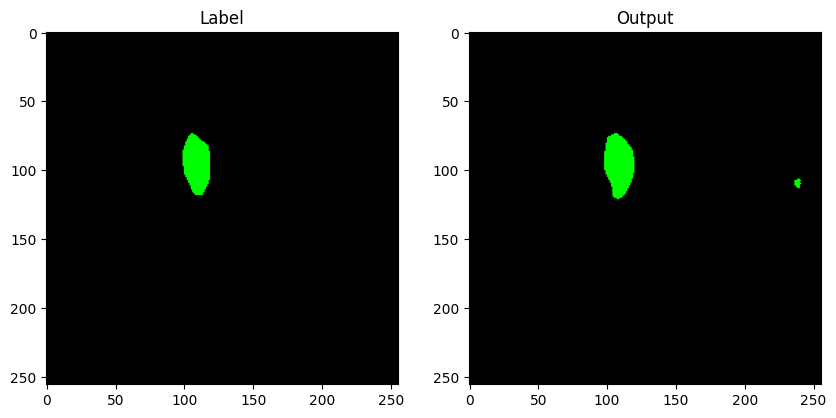

Epoch [48/180], Loss: 0.0945423251


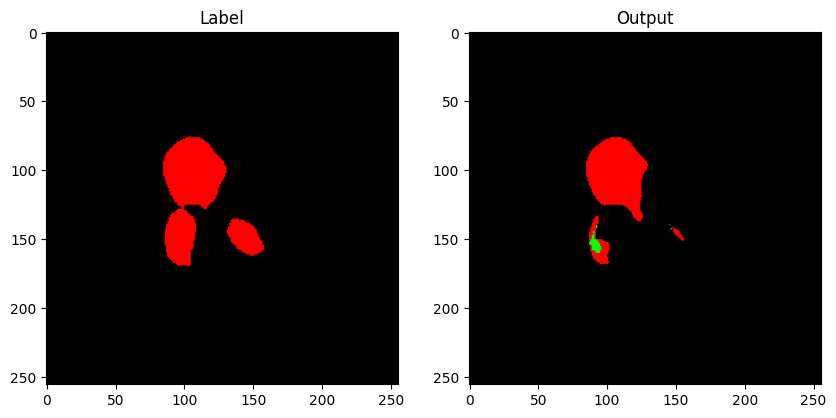

Epoch [49/180], Loss: 0.0929140279


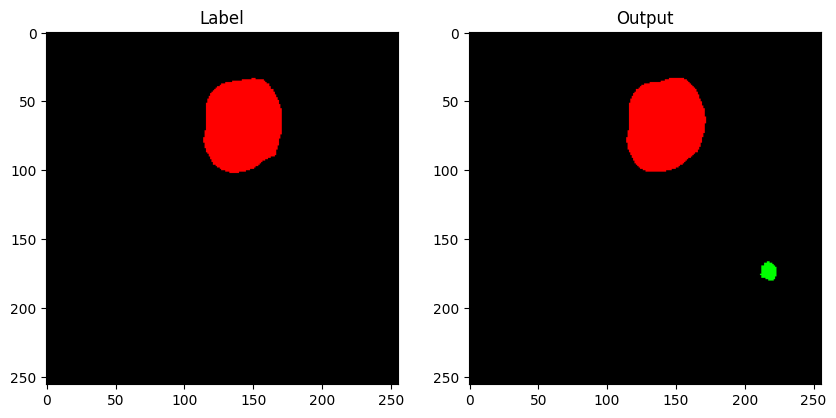

Epoch [50/180], Loss: 0.0936625237


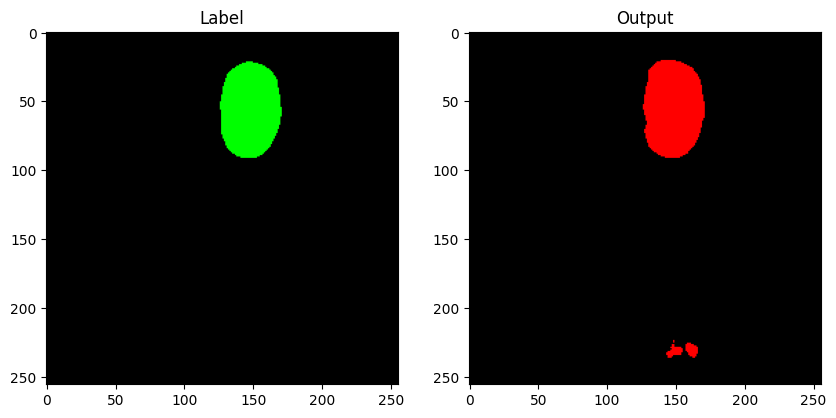

Epoch [51/180], Loss: 0.1032612500


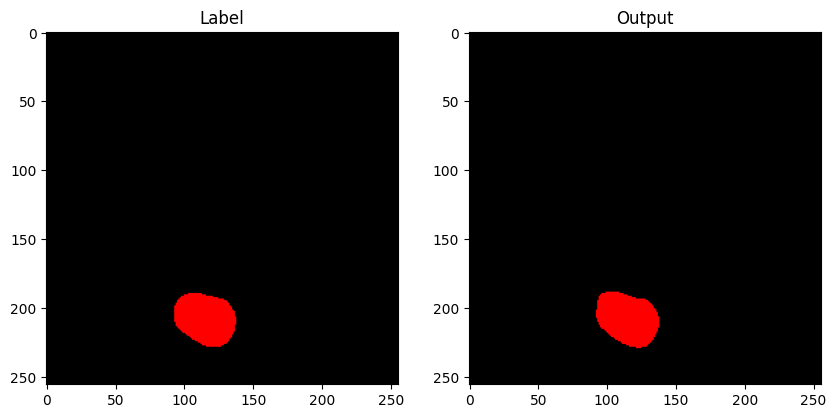

Epoch [52/180], Loss: 0.1035705698


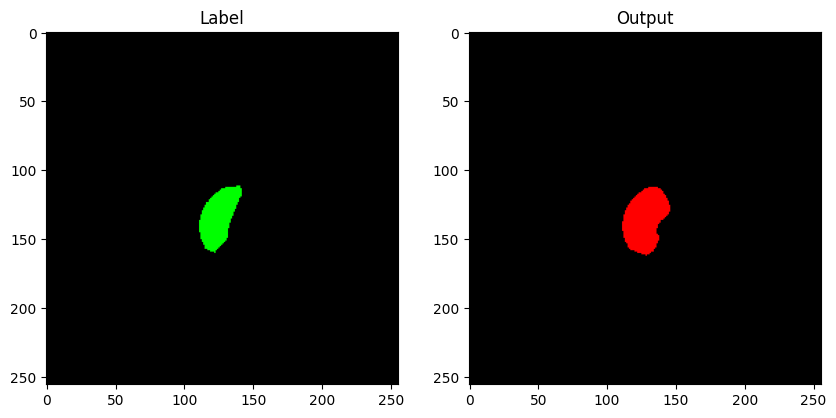

Epoch [53/180], Loss: 0.1029241894


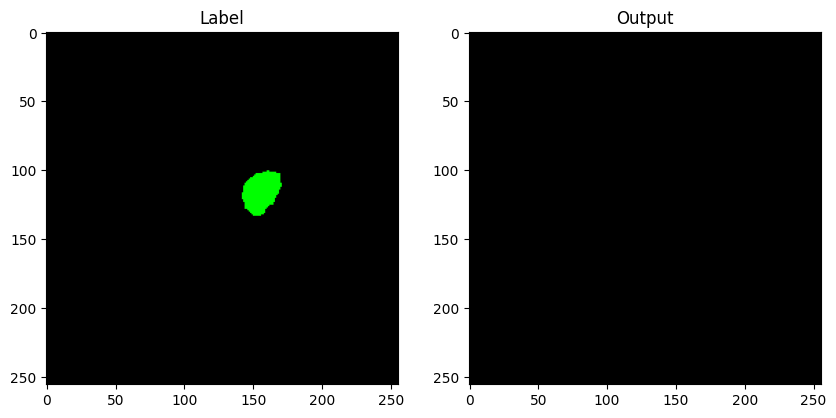

Epoch [54/180], Loss: 0.1008155142


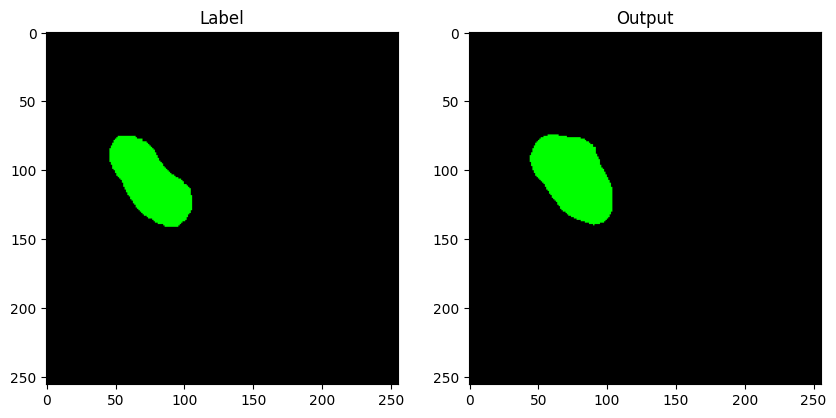

Epoch [55/180], Loss: 0.1058424397


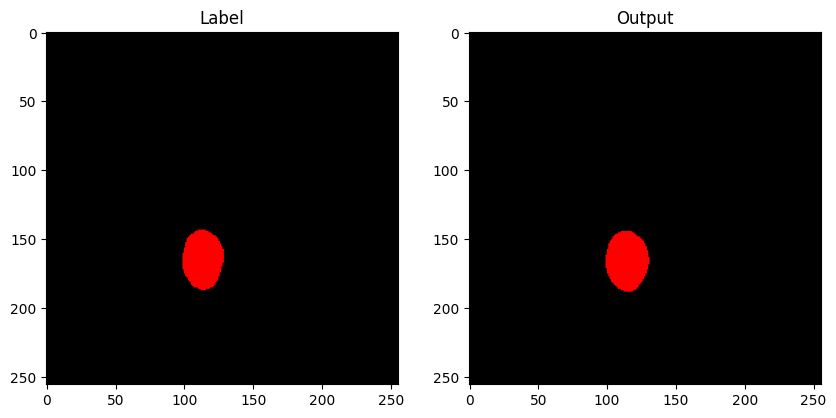

Epoch [56/180], Loss: 0.1049739992


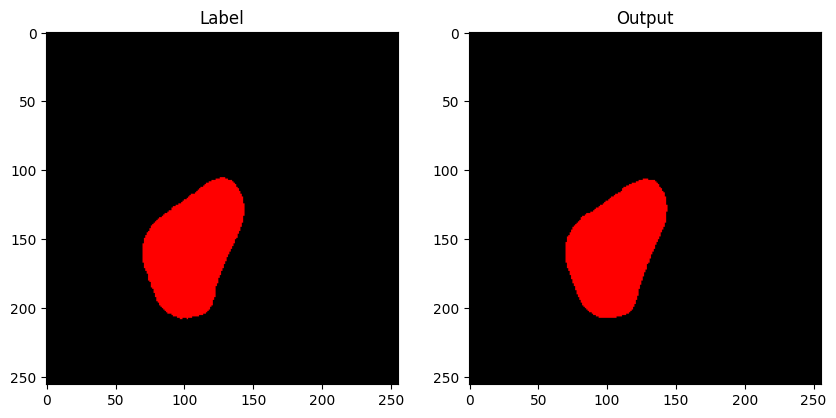

Epoch [57/180], Loss: 0.1418646663


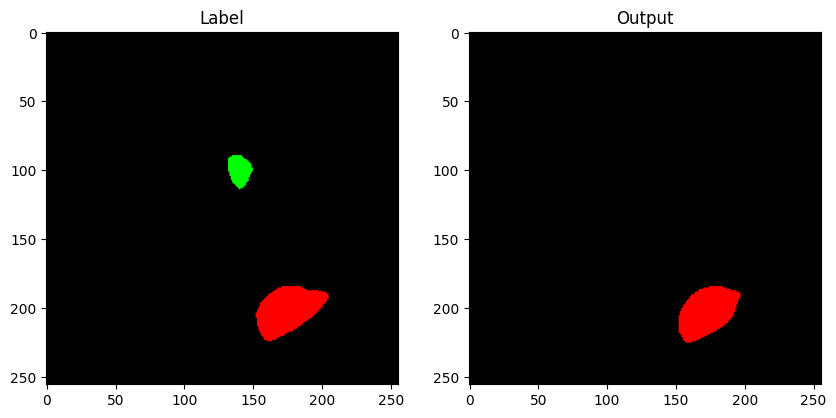

Epoch [58/180], Loss: 0.1051955389


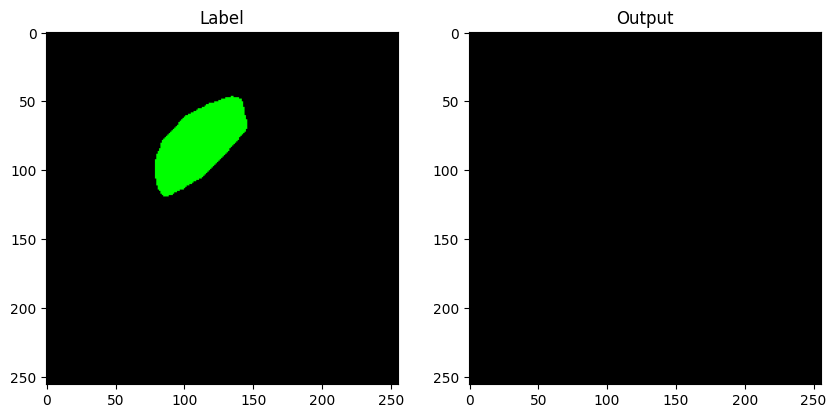

Epoch [59/180], Loss: 0.1040287466


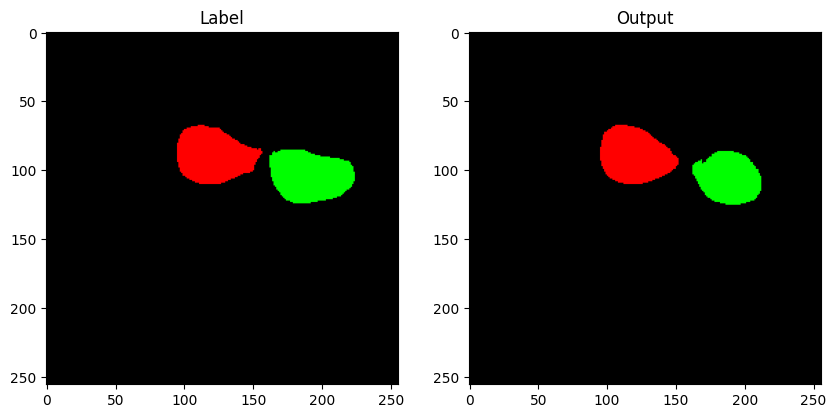

Epoch [60/180], Loss: 0.1039649234


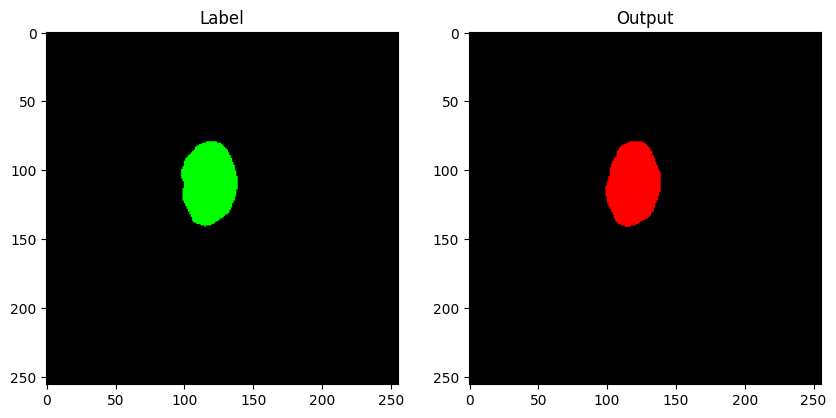

Epoch [61/180], Loss: 0.1135488909


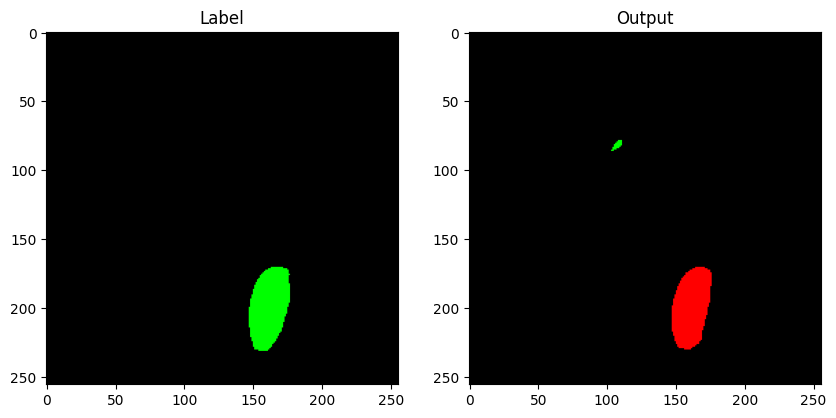

Epoch [62/180], Loss: 0.1062272157


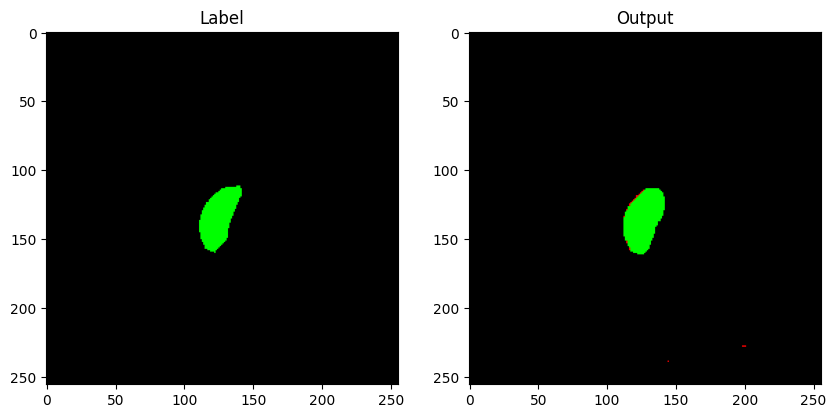

Epoch [63/180], Loss: 0.1040395017


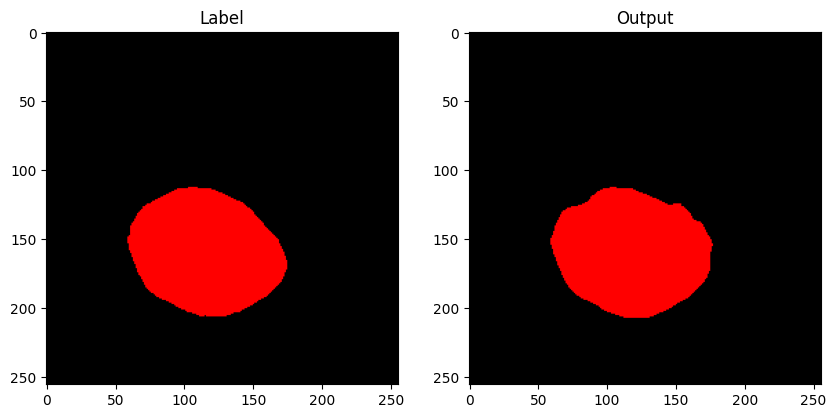

Epoch [64/180], Loss: 0.1032523519


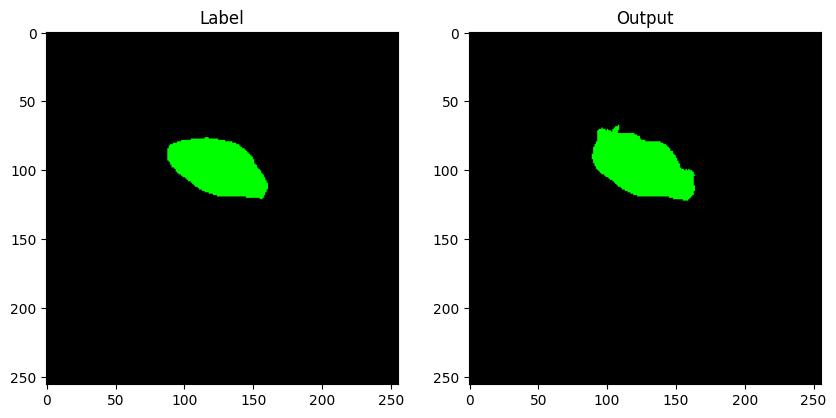

Epoch [65/180], Loss: 0.1159724148


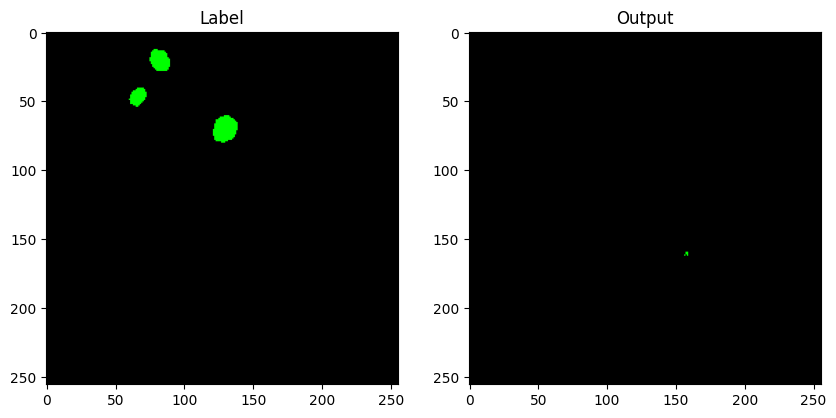

Epoch [66/180], Loss: 0.1178834460


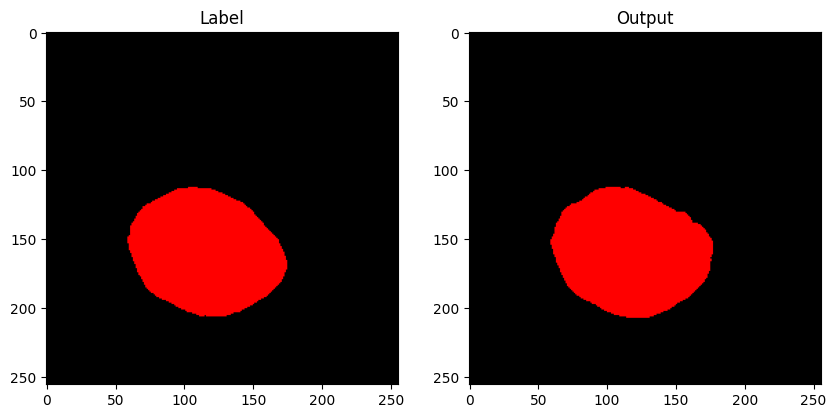

Epoch [67/180], Loss: 0.1110191784


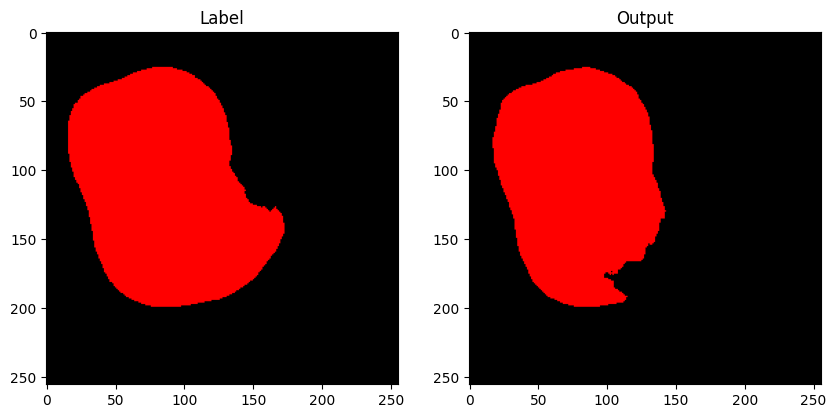

Epoch [68/180], Loss: 0.1090844347


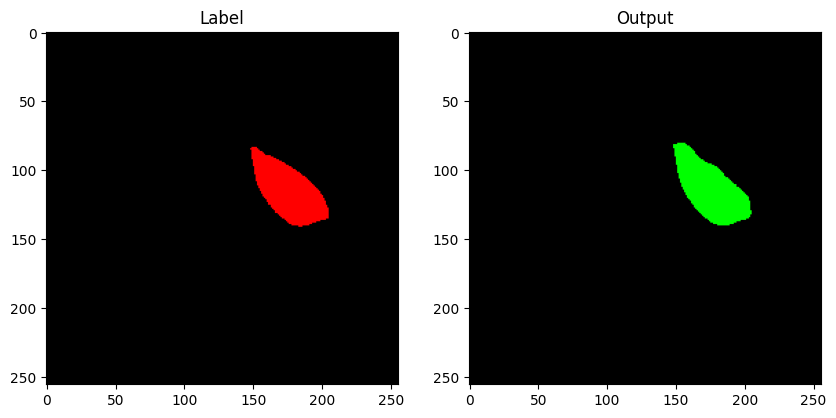

Epoch [69/180], Loss: 0.1156408350


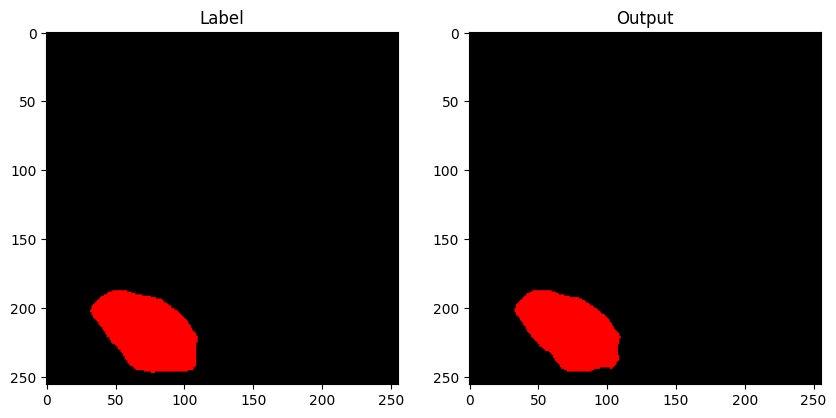

Epoch [70/180], Loss: 0.1144899527


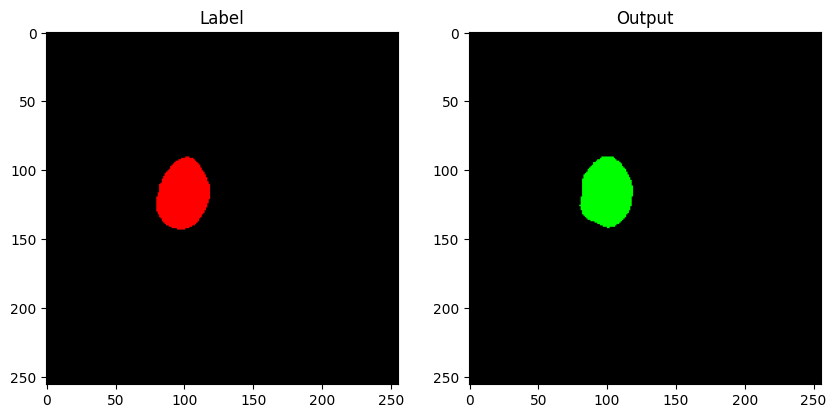

Epoch [71/180], Loss: 0.1090493328


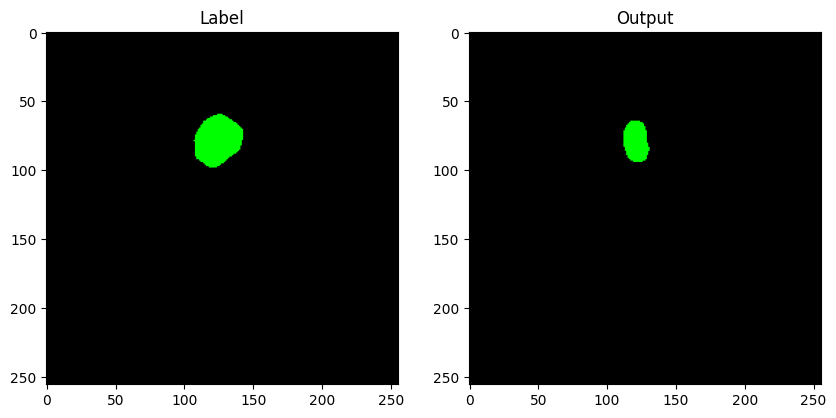

Epoch [72/180], Loss: 0.1148721782


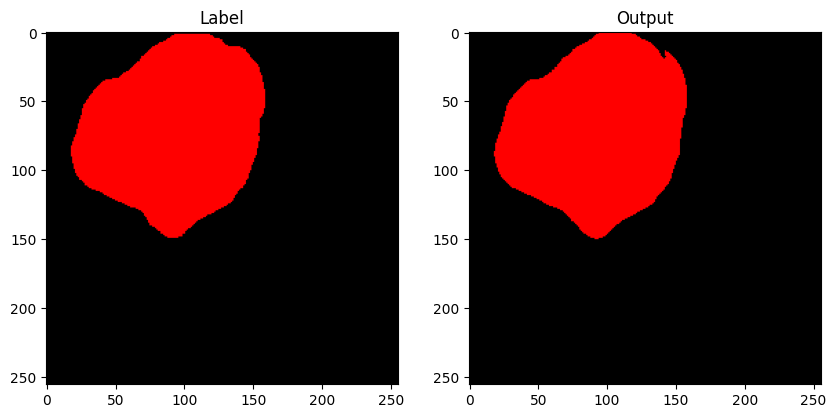

Epoch [73/180], Loss: 0.1159043878


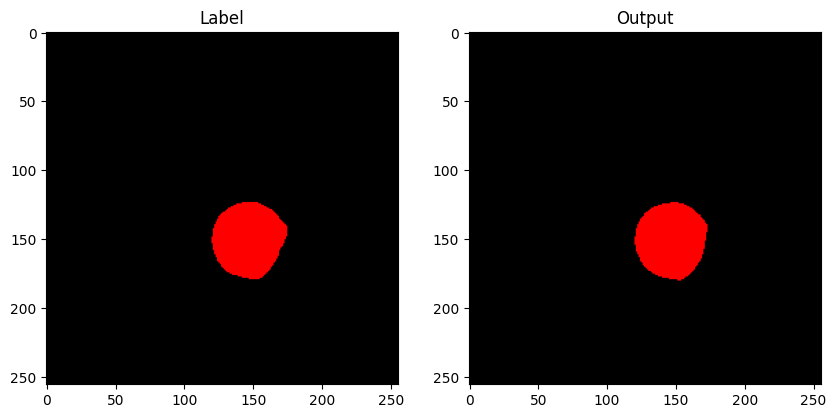

Epoch [74/180], Loss: 0.1160708083


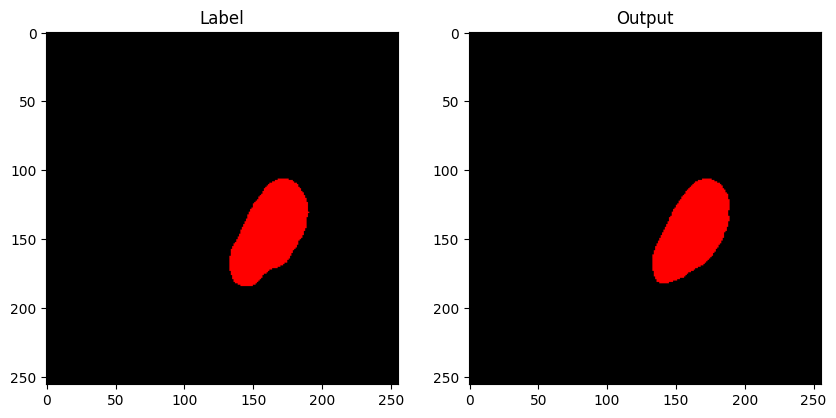

Epoch [75/180], Loss: 0.1184014161


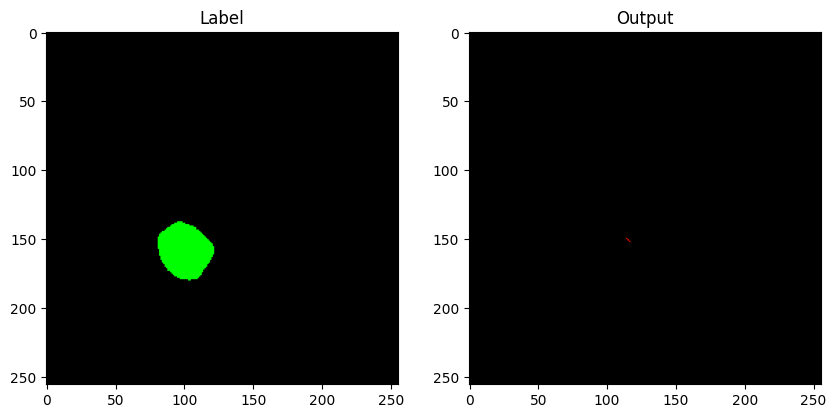

Epoch [76/180], Loss: 0.1230268235


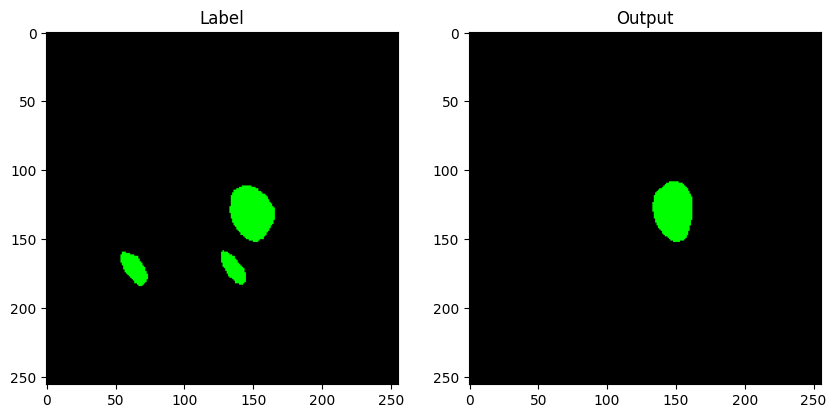

Epoch [77/180], Loss: 0.1183187049


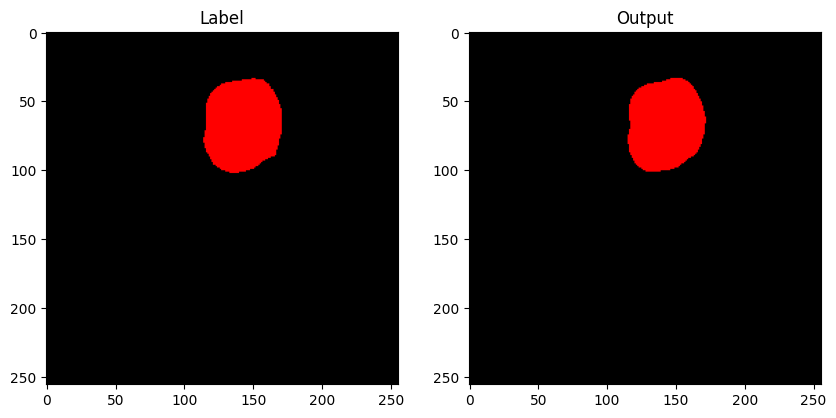

Epoch [78/180], Loss: 0.1650290688


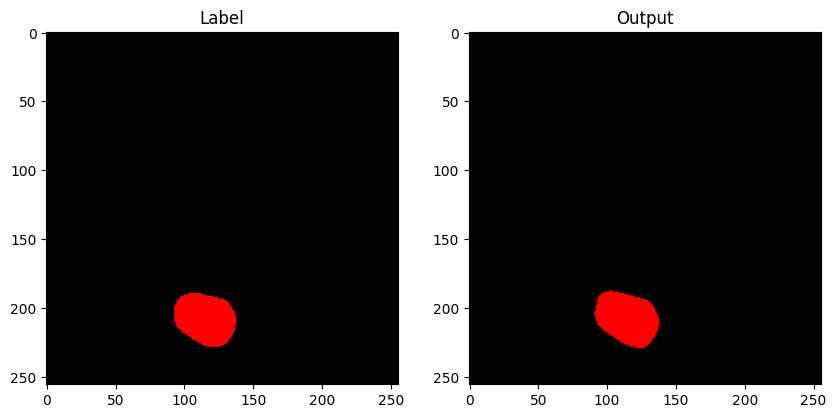

Epoch [79/180], Loss: 0.1623195510


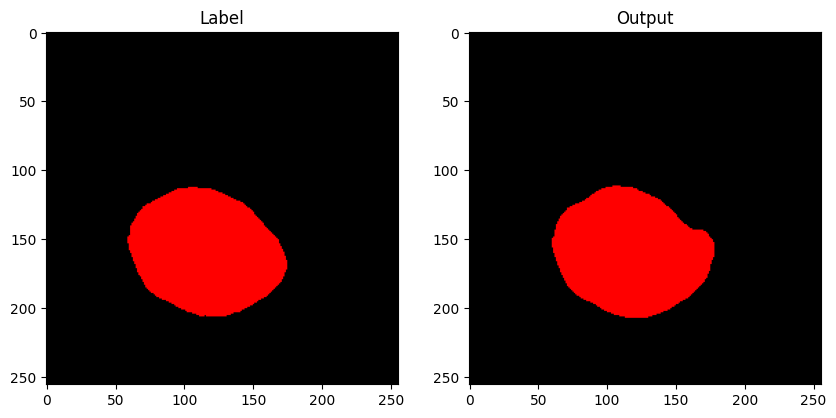

Epoch [80/180], Loss: 0.1188209735


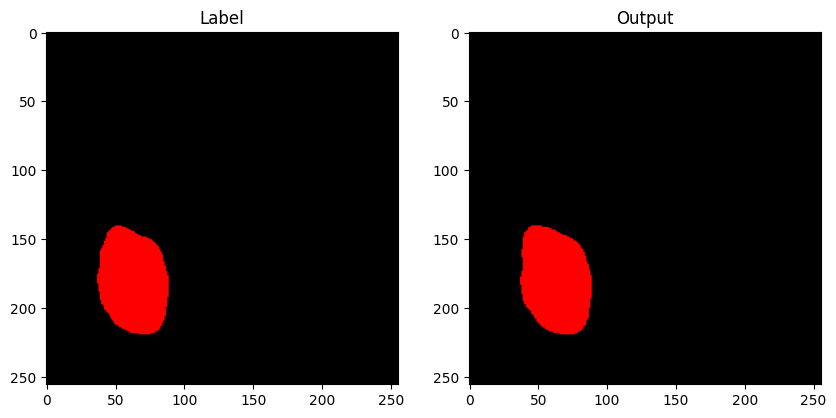

Epoch [81/180], Loss: 0.1276159063


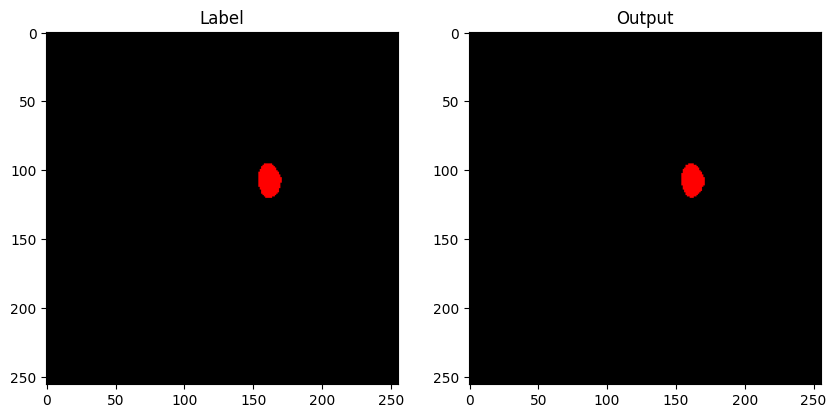

Epoch [82/180], Loss: 0.1227116562


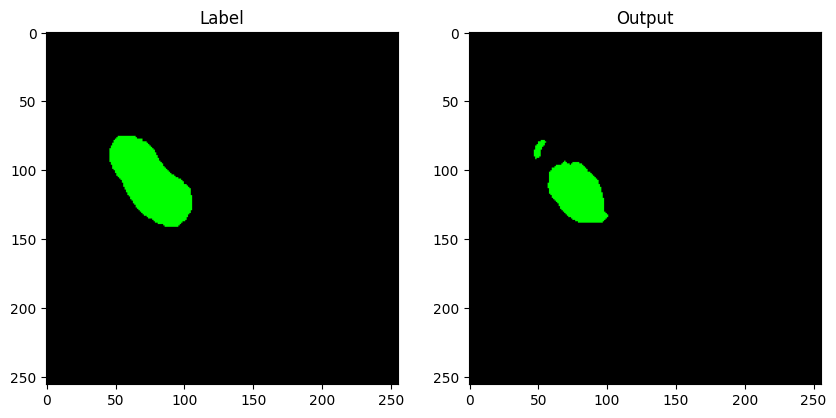

Epoch [83/180], Loss: 0.0911389369


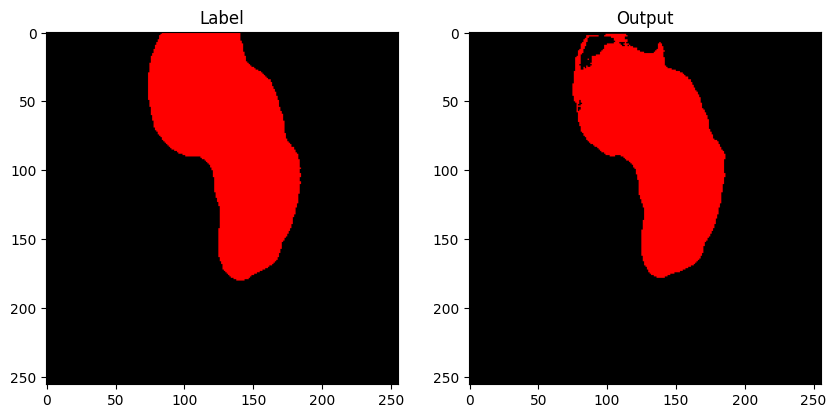

Epoch [84/180], Loss: 0.1009926412


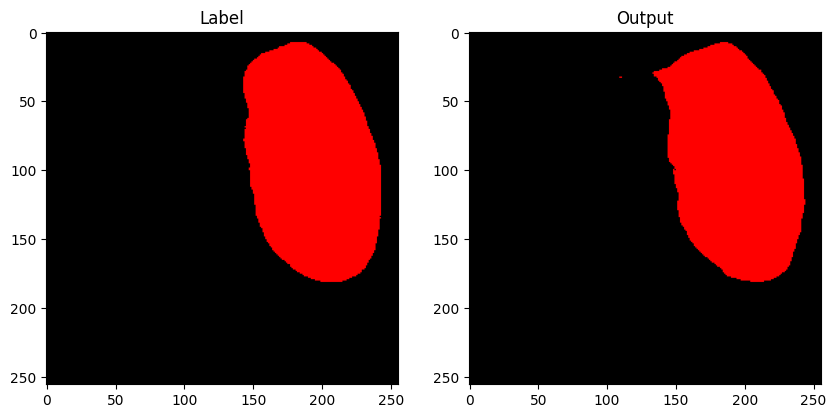

Epoch [85/180], Loss: 0.0915603373


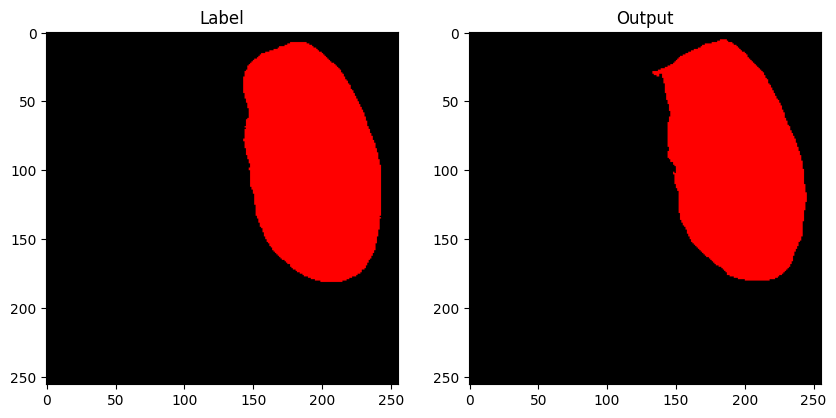

Epoch [86/180], Loss: 0.1056363320


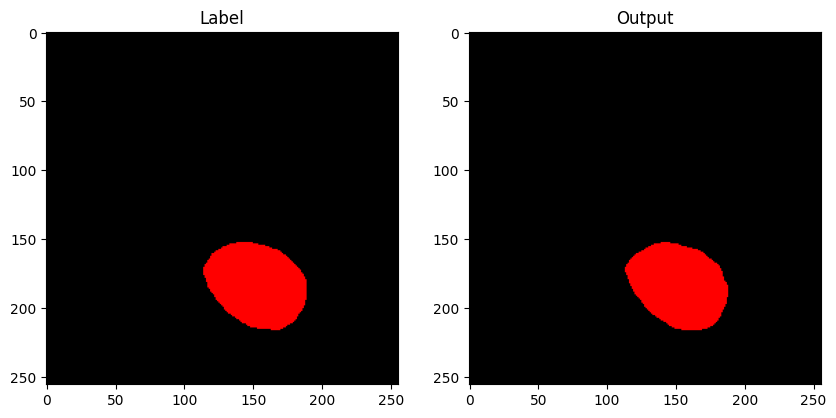

Epoch [87/180], Loss: 0.1041535463


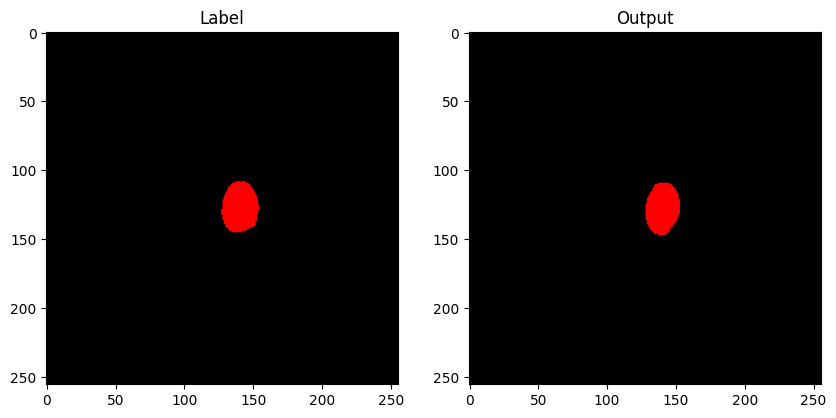

Epoch [88/180], Loss: 0.1076898612


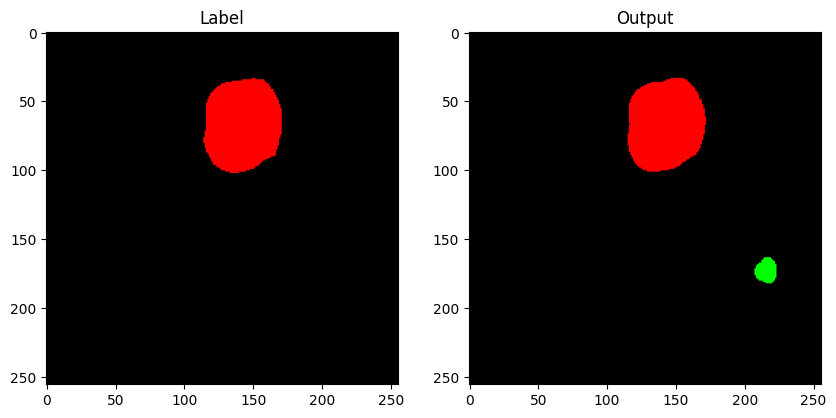

Epoch [89/180], Loss: 0.1104219675


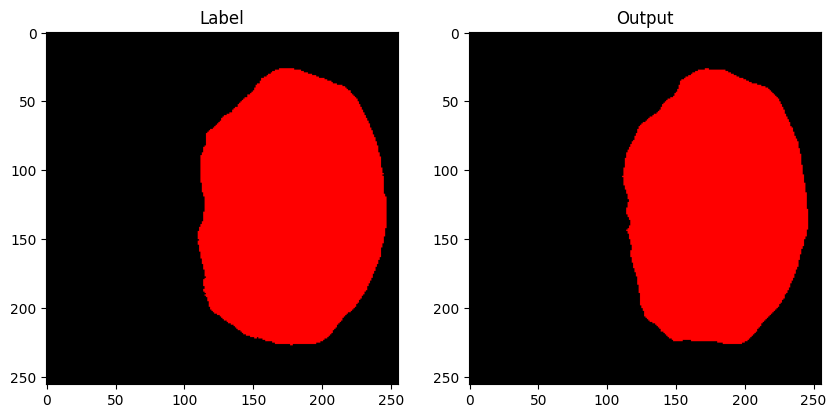

Epoch [90/180], Loss: 0.1086185877


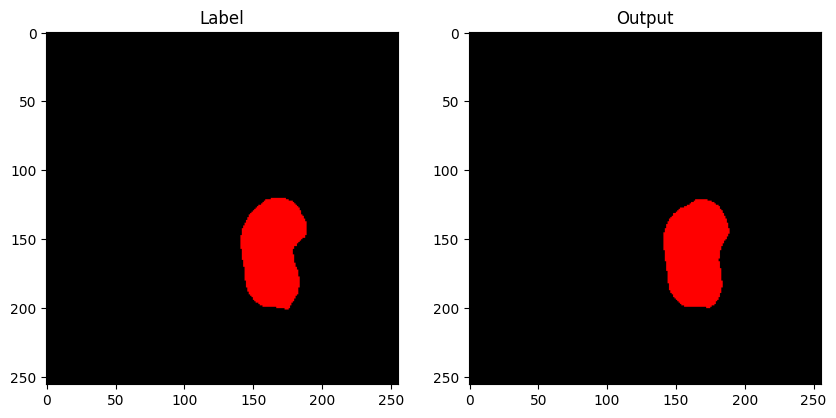

Epoch [91/180], Loss: 0.1009785752


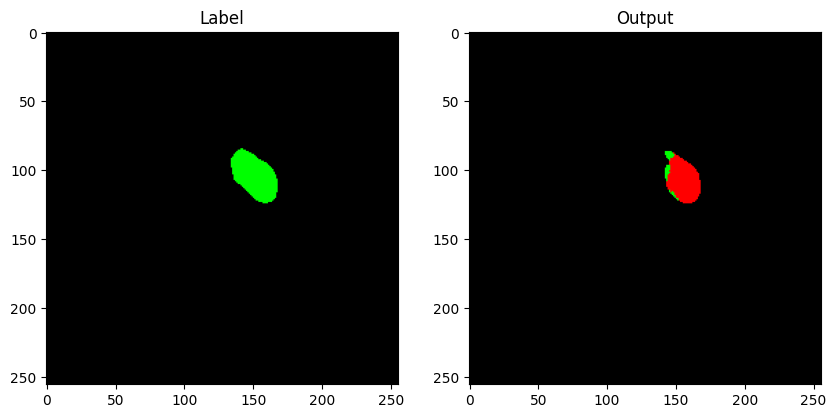

Epoch [92/180], Loss: 0.1542152462


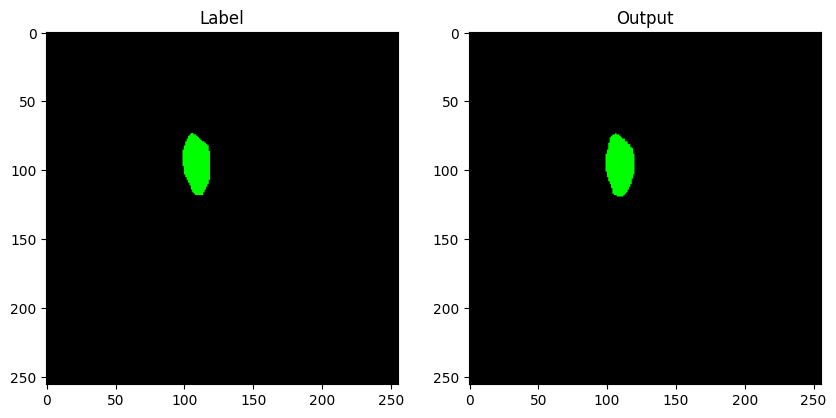

Epoch [93/180], Loss: 0.1085197797


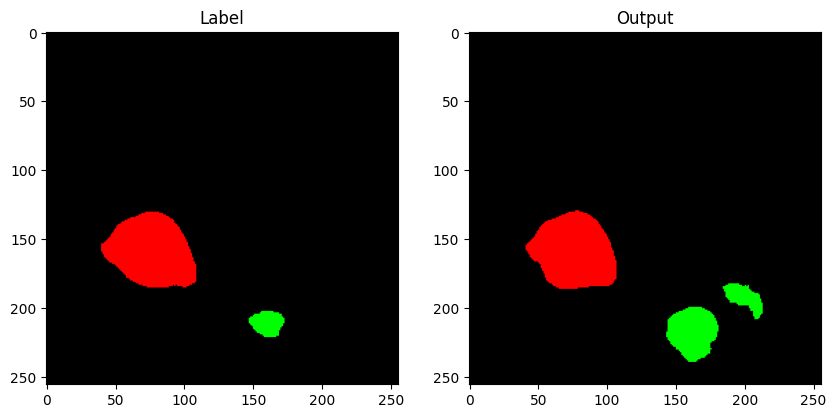

Epoch [94/180], Loss: 0.1256555004


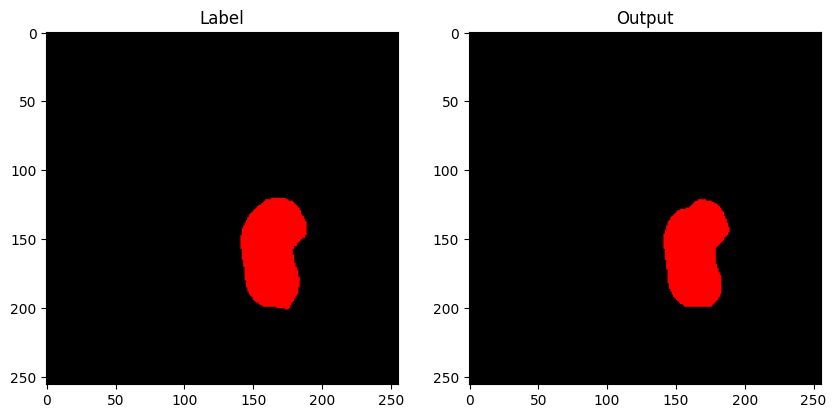

Epoch [95/180], Loss: 0.1145574154


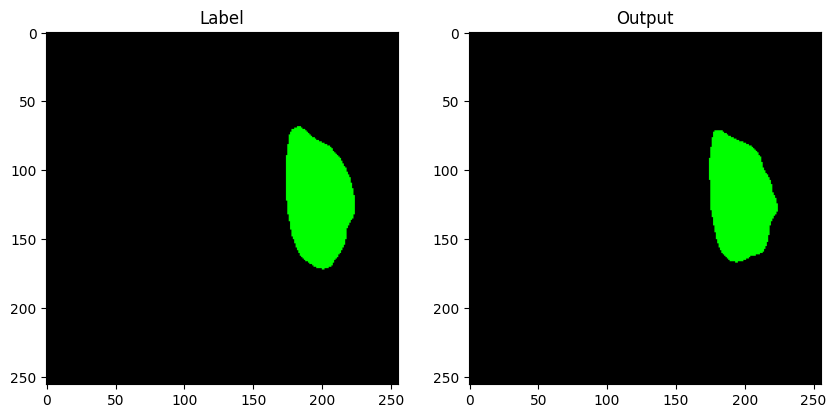

Epoch [96/180], Loss: 0.1061967402


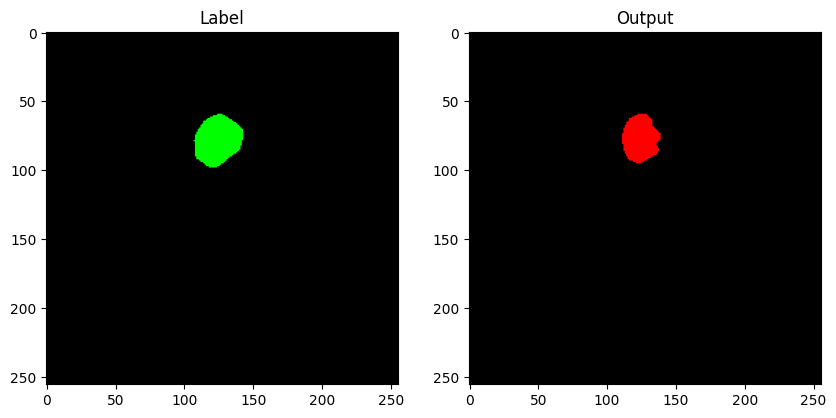

Epoch [97/180], Loss: 0.1151153044


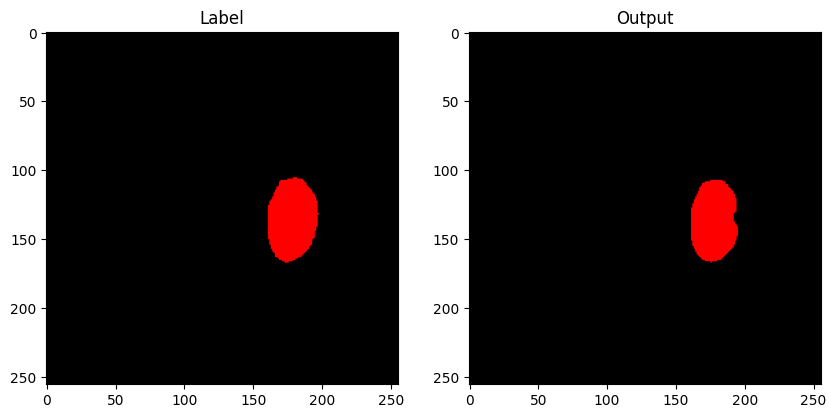

Epoch [98/180], Loss: 0.1251858155


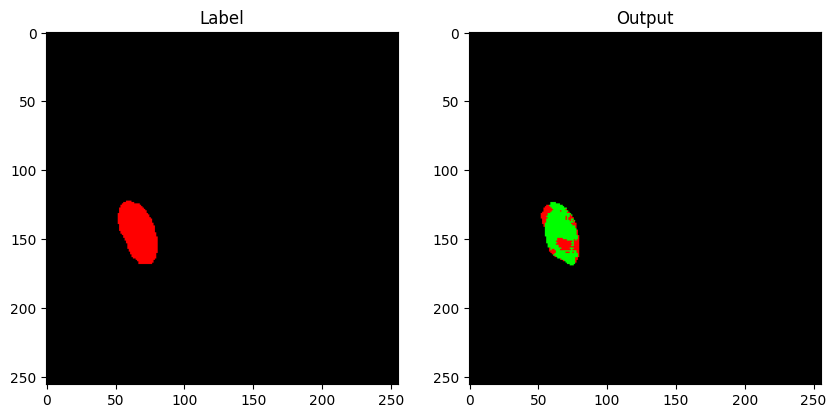

Epoch [99/180], Loss: 0.1051574216


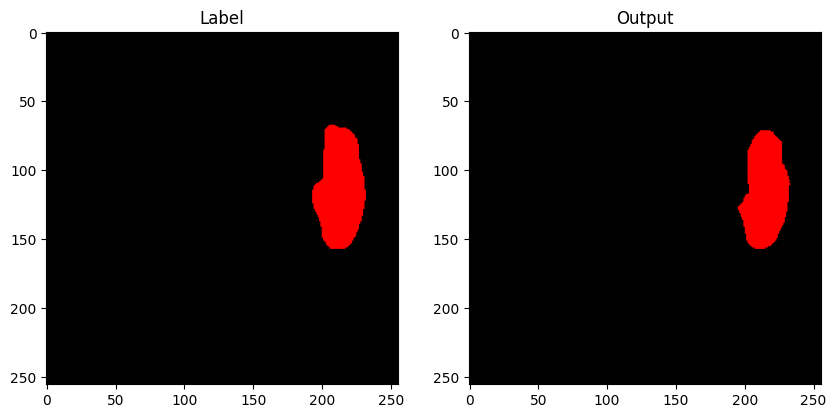

Epoch [100/180], Loss: 0.1072410320


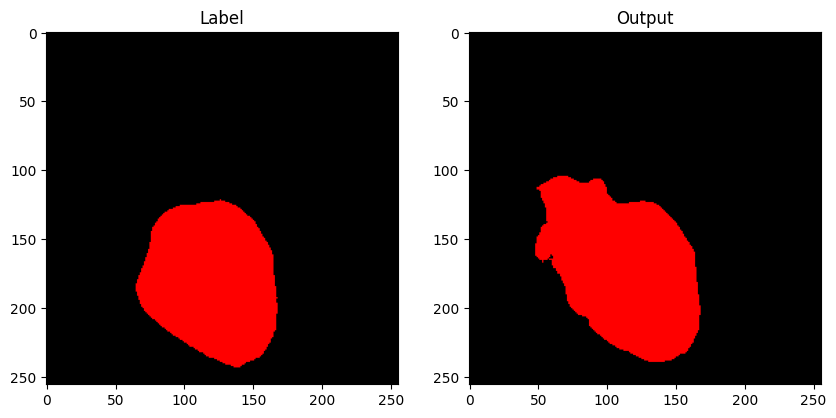

Epoch [101/180], Loss: 0.1023475283


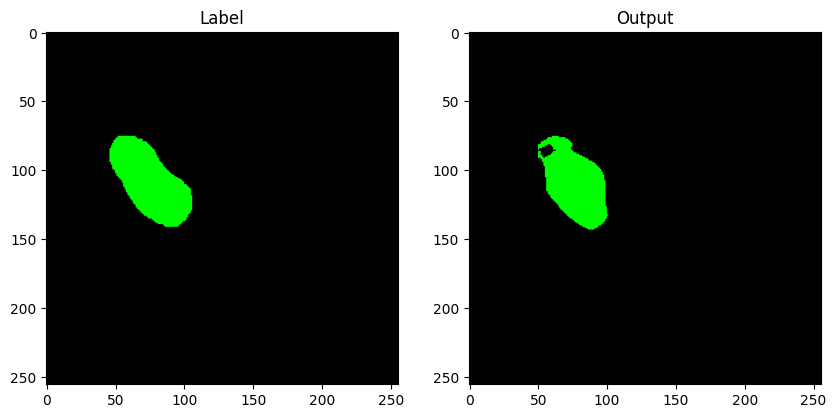

Epoch [102/180], Loss: 0.1024913647


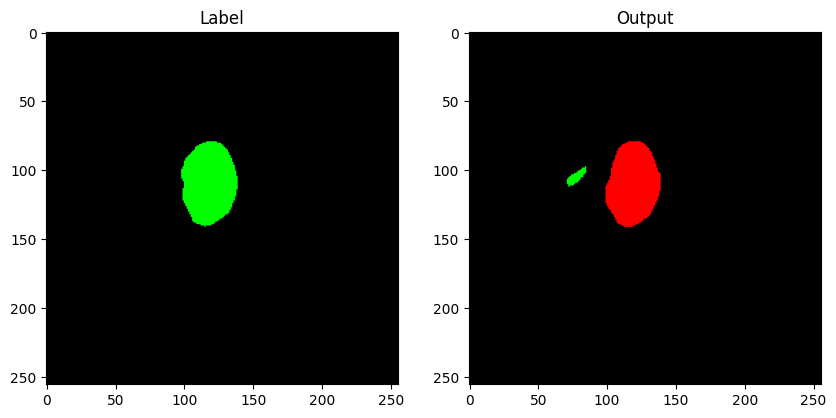

Epoch [103/180], Loss: 0.1105142508


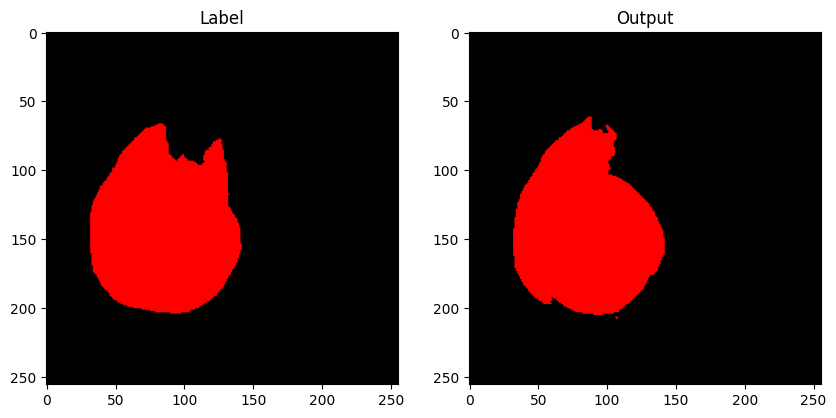

Epoch [104/180], Loss: 0.1123675688


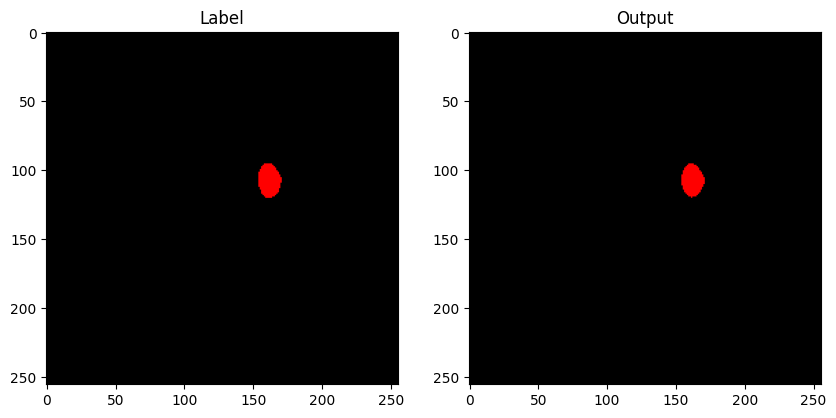

Epoch [105/180], Loss: 0.1175604618


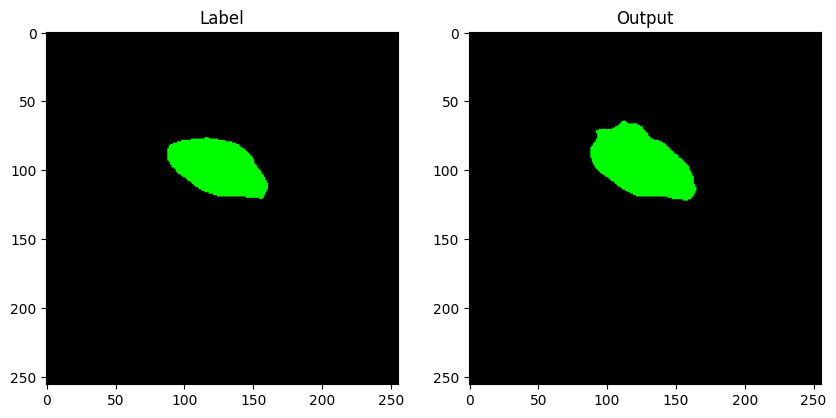

Epoch [106/180], Loss: 0.1154036327


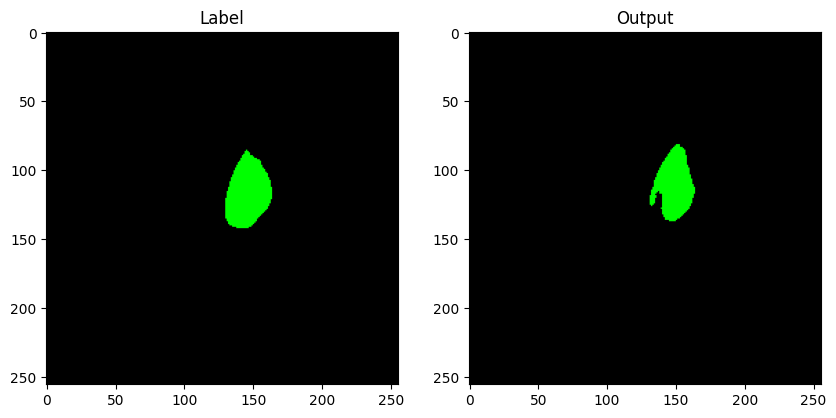

Epoch [107/180], Loss: 0.1135464255


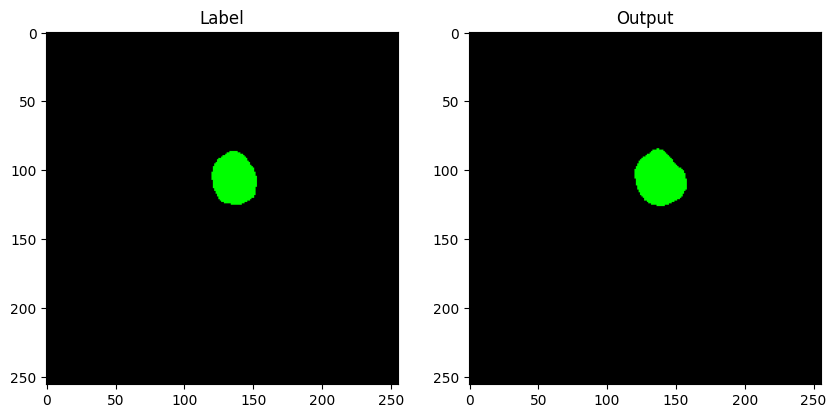

Epoch [108/180], Loss: 0.1184741296


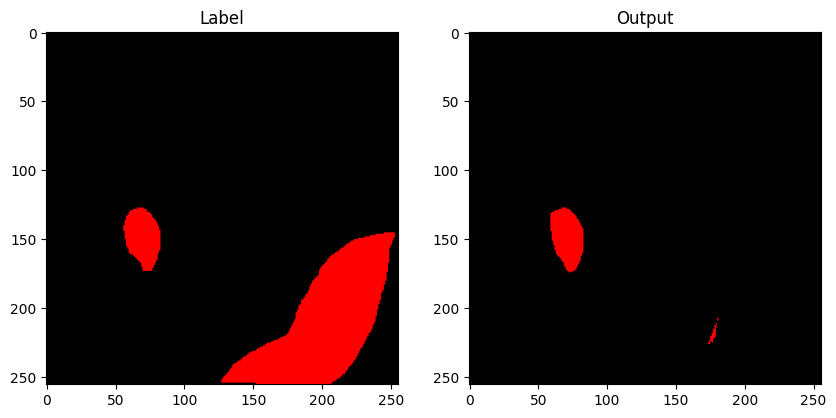

Epoch [109/180], Loss: 0.1277784649


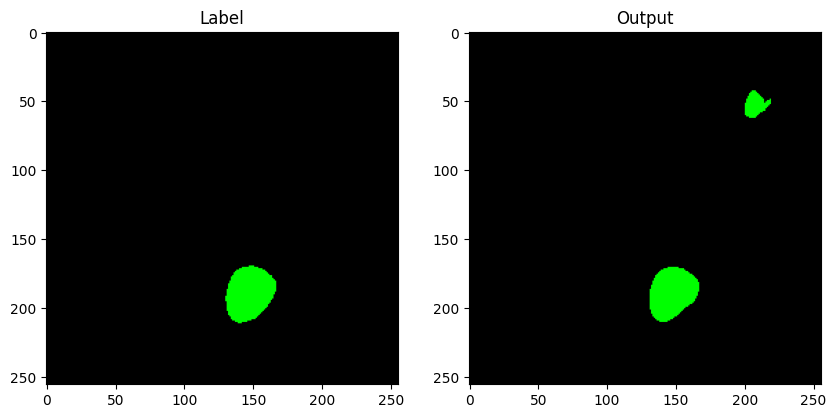

Epoch [110/180], Loss: 0.1187419418


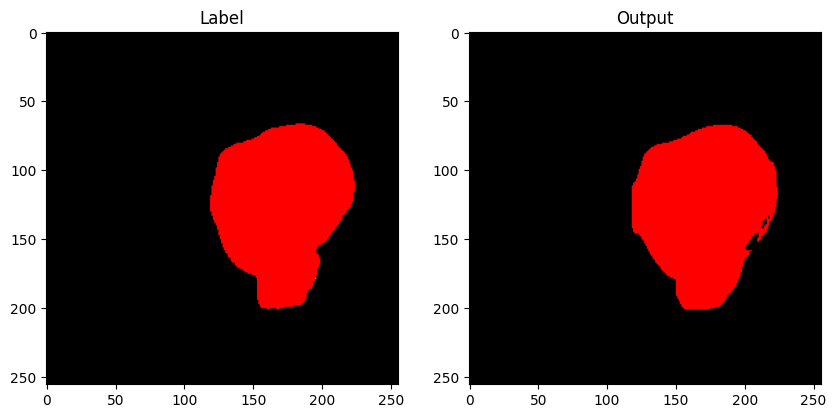

Epoch [111/180], Loss: 0.1293990728


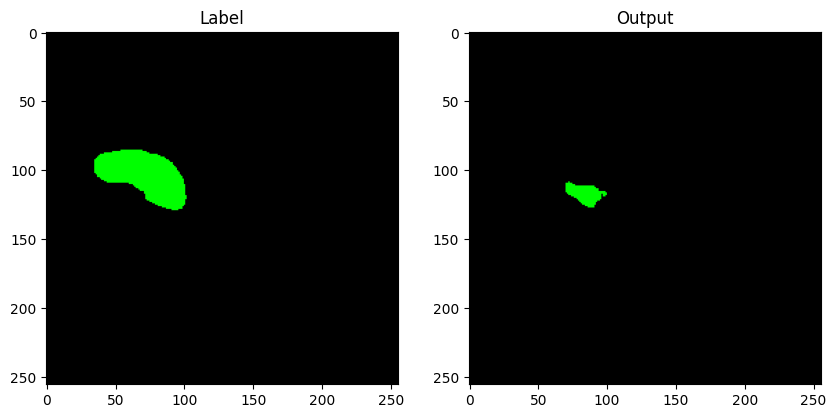

Epoch [112/180], Loss: 0.1304683258


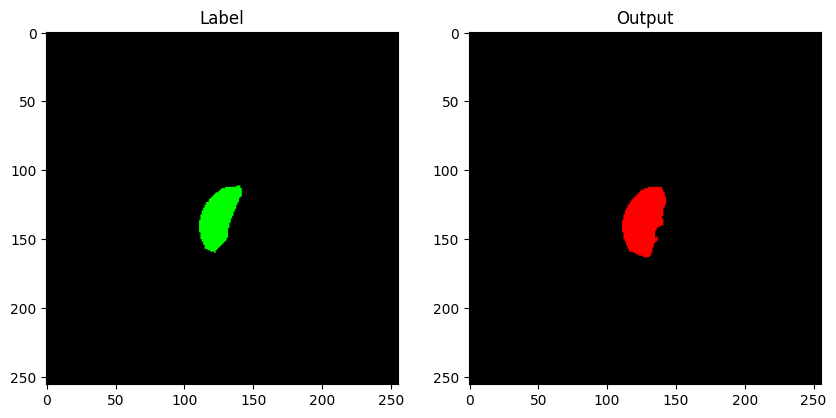

Epoch [113/180], Loss: 0.1254380159


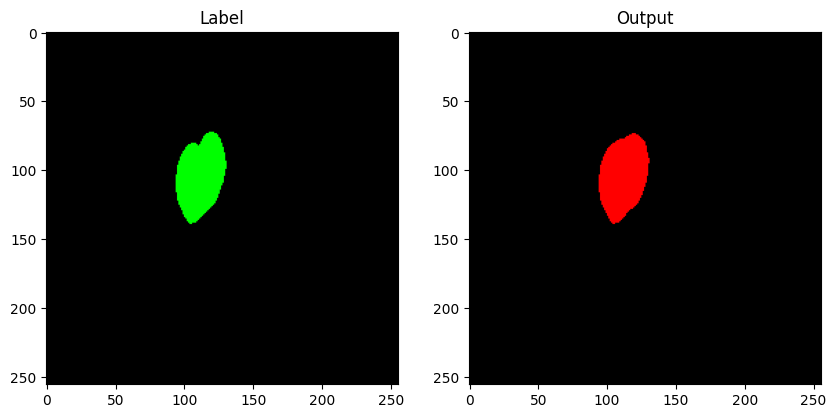

Epoch [114/180], Loss: 0.1185351242


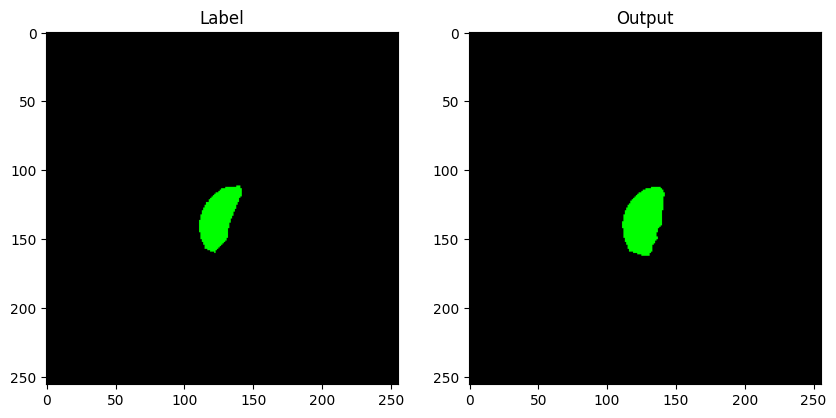

Epoch [115/180], Loss: 0.1216205480


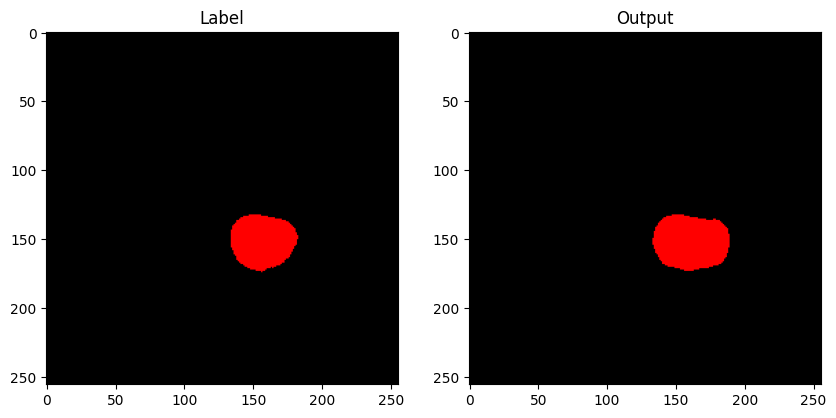

Epoch [116/180], Loss: 0.1270889468


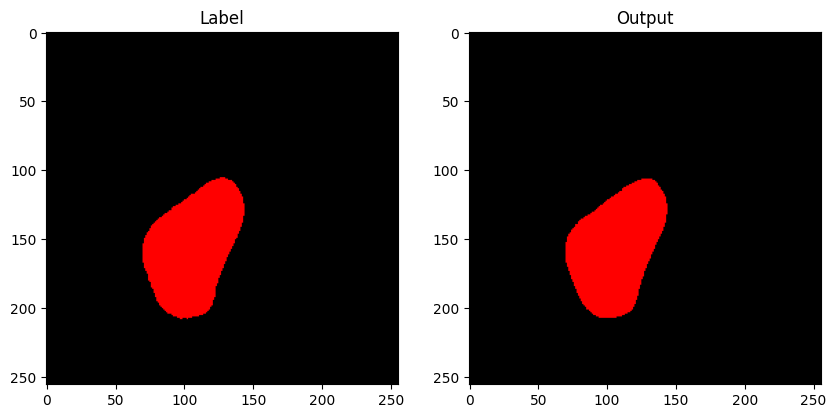

Epoch [117/180], Loss: 0.1345263724


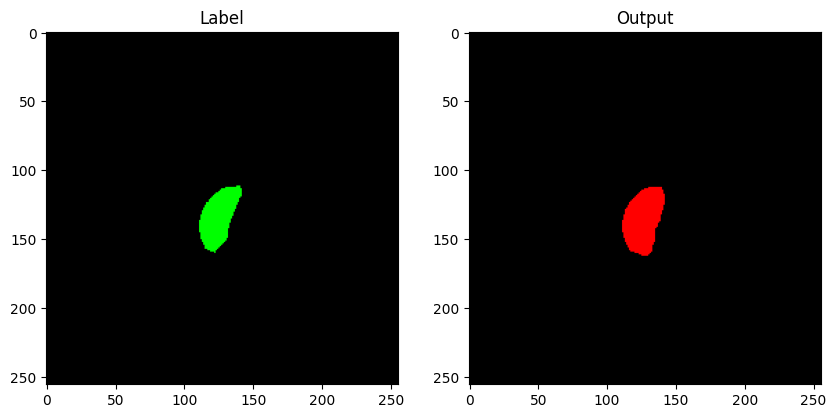

Epoch [118/180], Loss: 0.1267372573


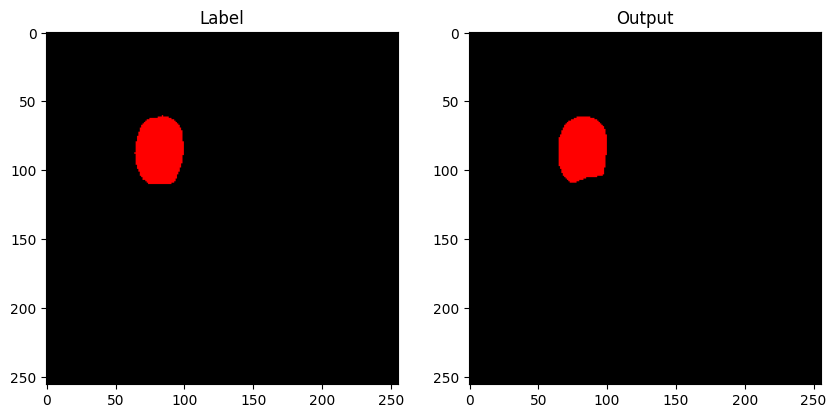

Epoch [119/180], Loss: 0.1196874708


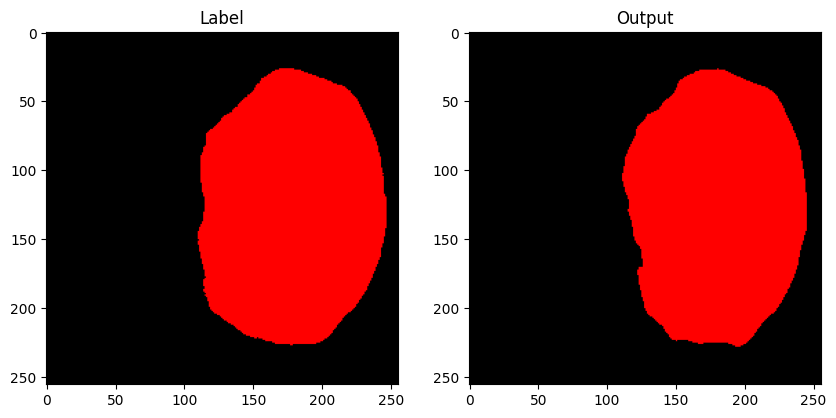

Epoch [120/180], Loss: 0.1607371686


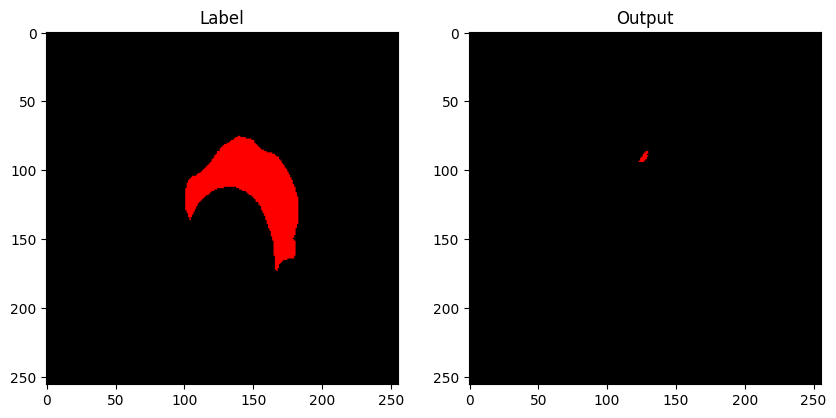

Epoch [121/180], Loss: 0.1168443019


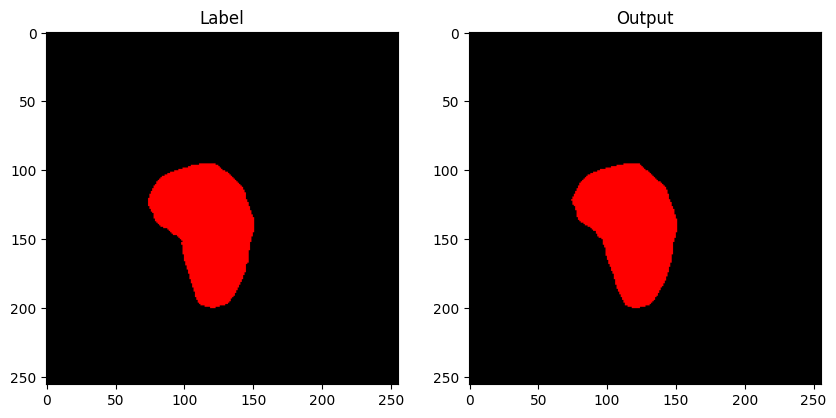

Epoch [122/180], Loss: 0.1293725146


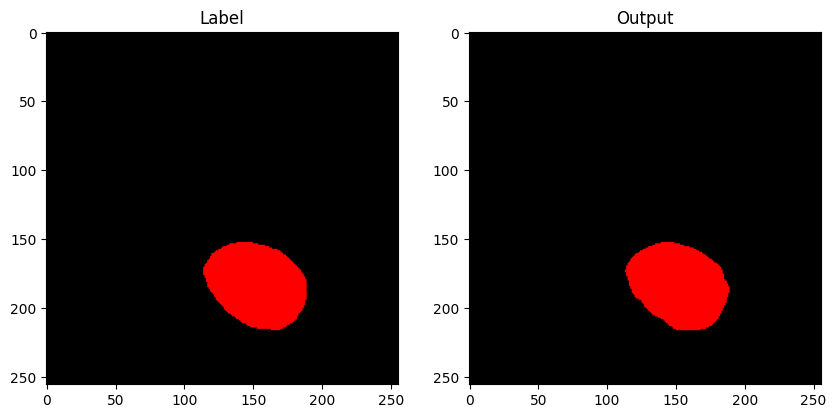

Epoch [123/180], Loss: 0.1262496799


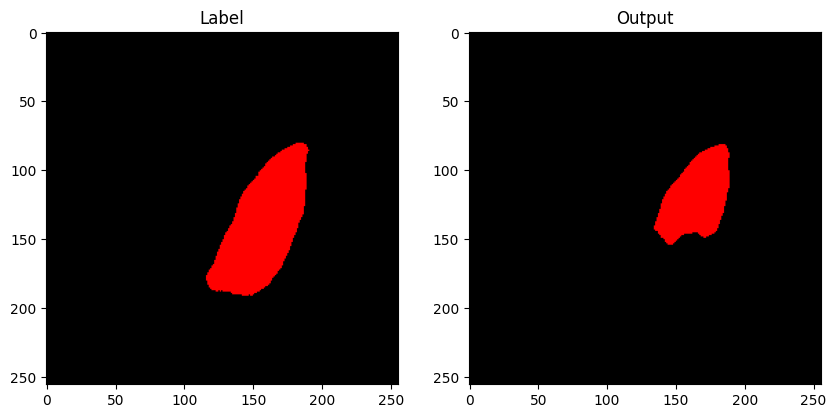

Epoch [124/180], Loss: 0.1217637989


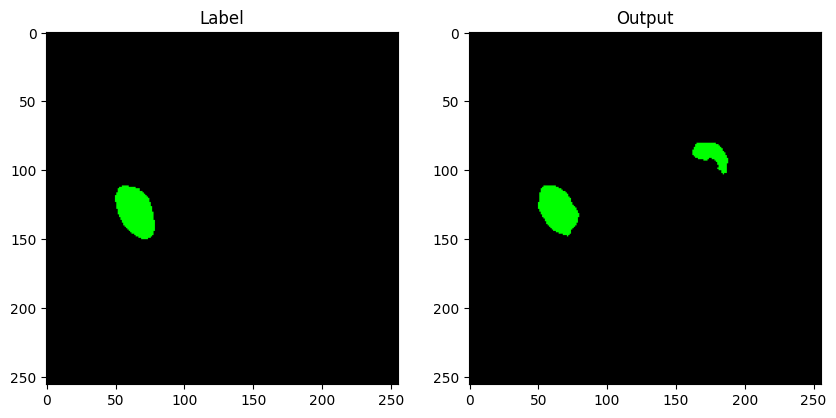

Epoch [125/180], Loss: 0.1376308292


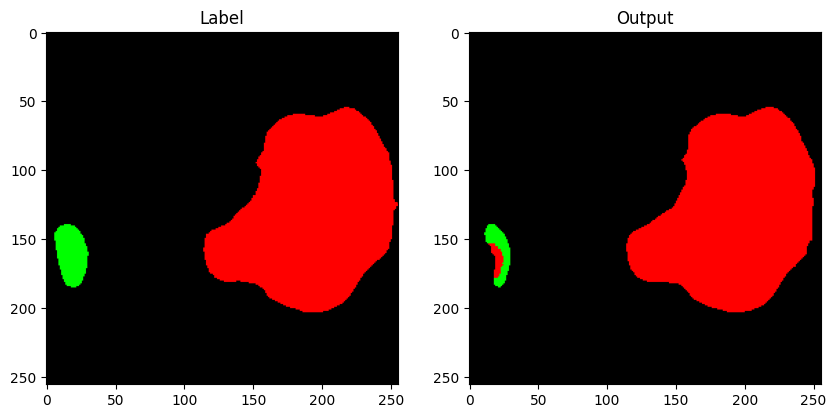

Epoch [126/180], Loss: 0.1425873577


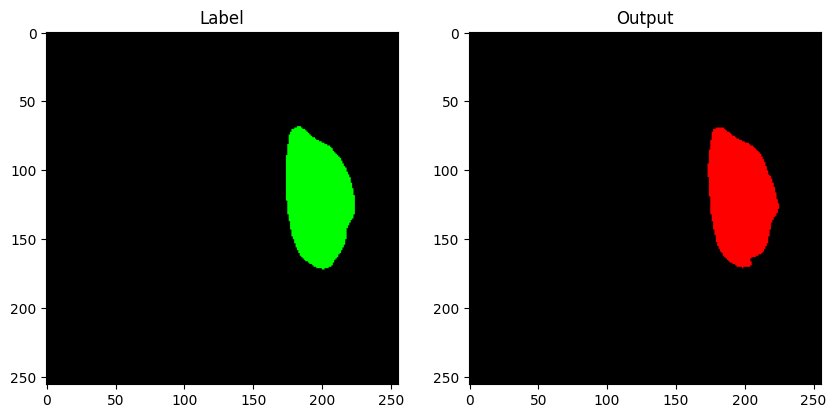

Epoch [127/180], Loss: 0.1365530153


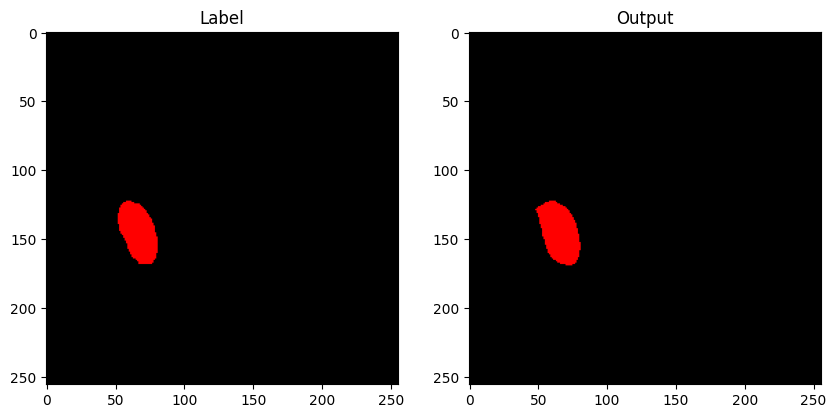

Epoch [128/180], Loss: 0.1334083267


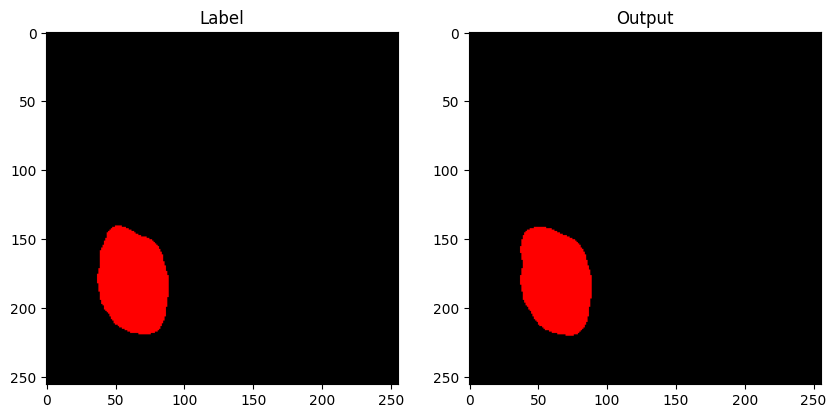

Epoch [129/180], Loss: 0.1217239392


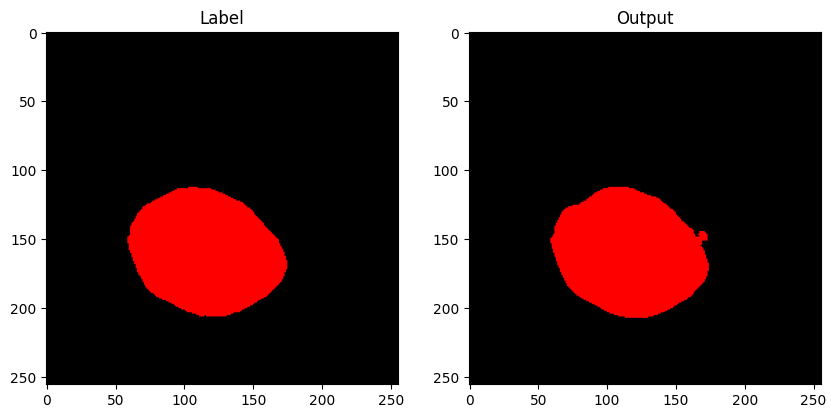

Epoch [130/180], Loss: 0.1344309789


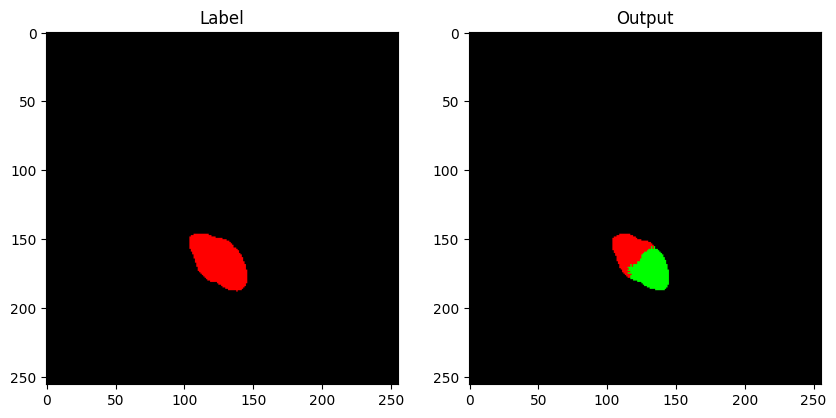

Epoch [131/180], Loss: 0.1446272772


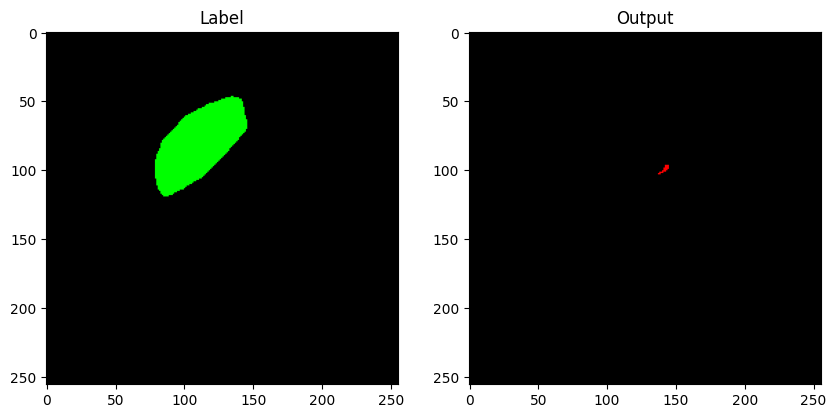

Epoch [132/180], Loss: 0.1313691060


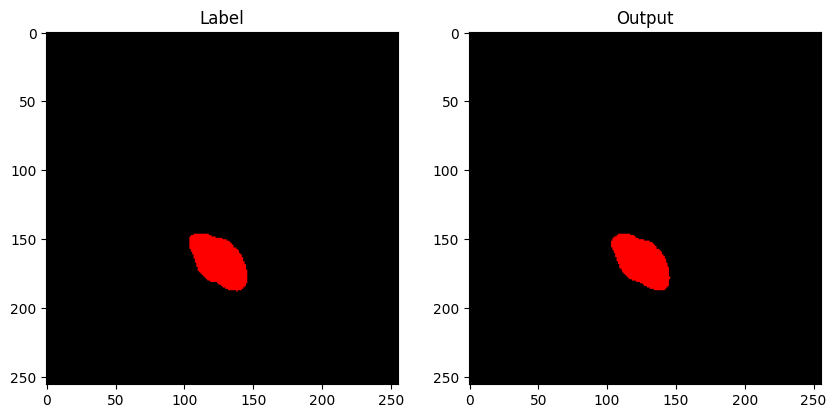

Epoch [133/180], Loss: 0.1336247735


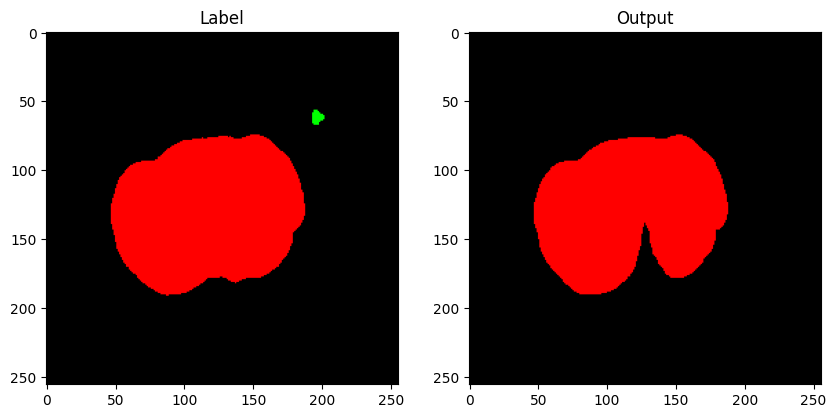

Epoch [134/180], Loss: 0.1344282221


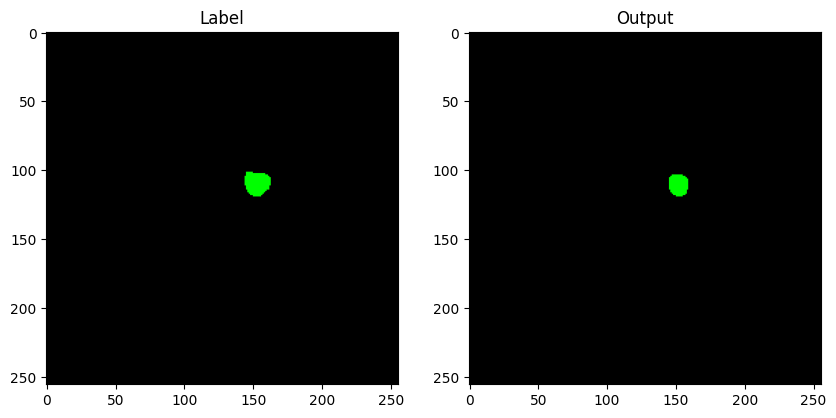

Epoch [135/180], Loss: 0.1487195220


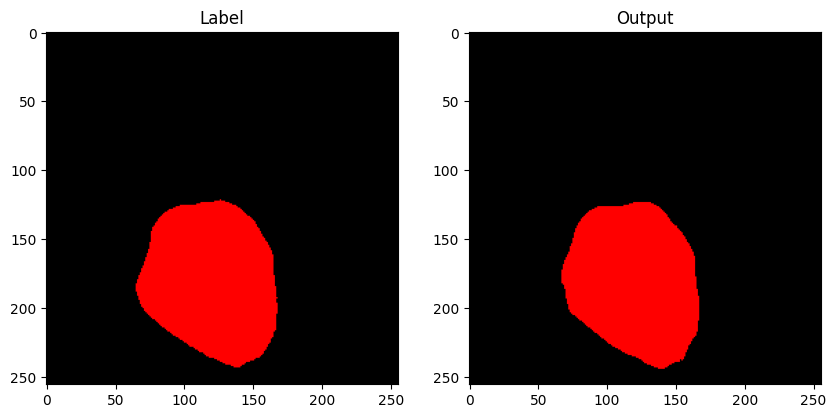

Epoch [136/180], Loss: 0.1126567816


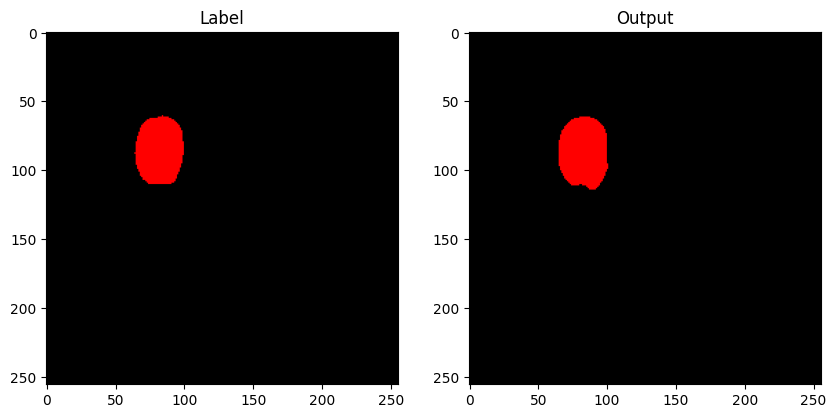

Epoch [137/180], Loss: 0.1133525326


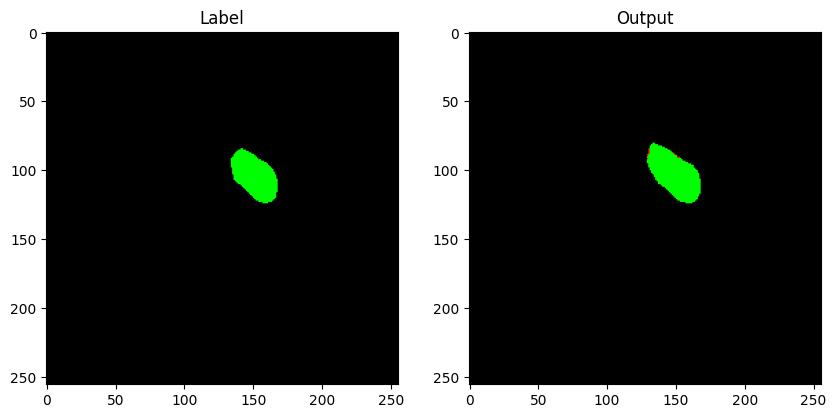

Epoch [138/180], Loss: 0.1376609407


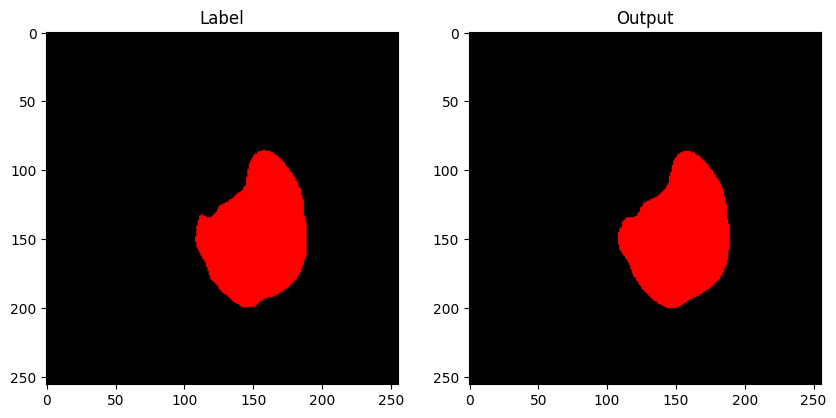

Epoch [139/180], Loss: 0.1166994568


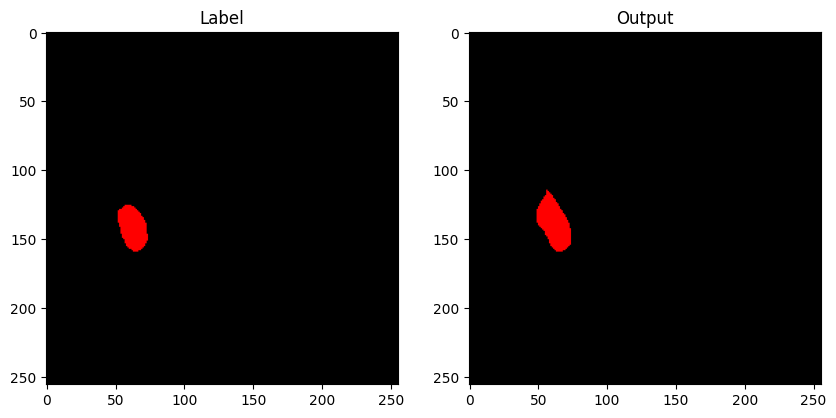

Epoch [140/180], Loss: 0.1227612660


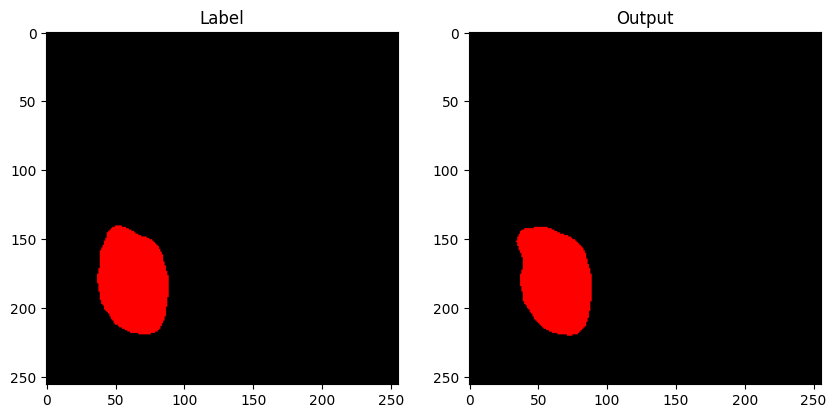

Epoch [141/180], Loss: 0.1229731299


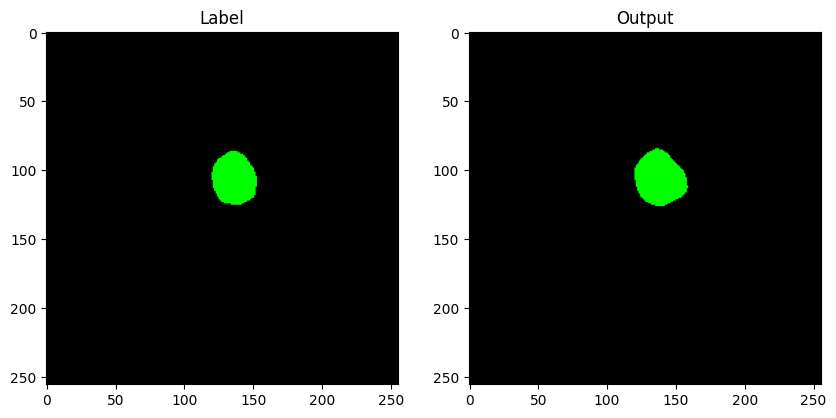

Epoch [142/180], Loss: 0.1318177943


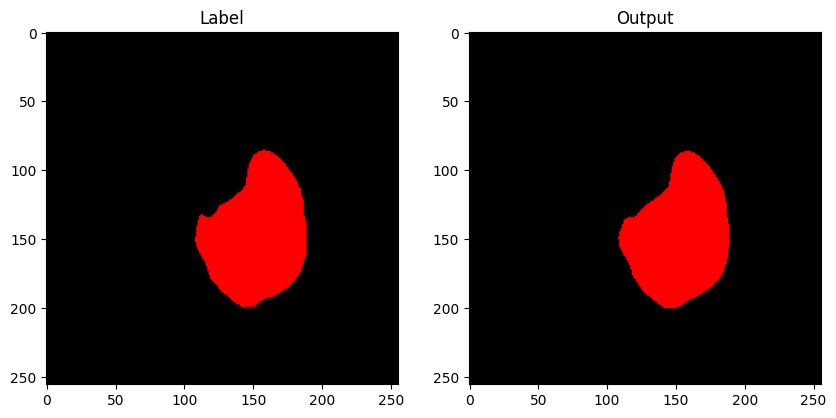

Epoch [143/180], Loss: 0.1316663500


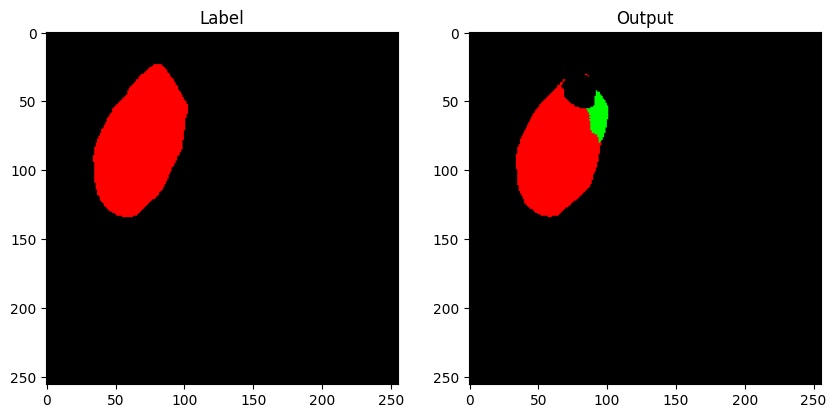

Epoch [144/180], Loss: 0.1323120297


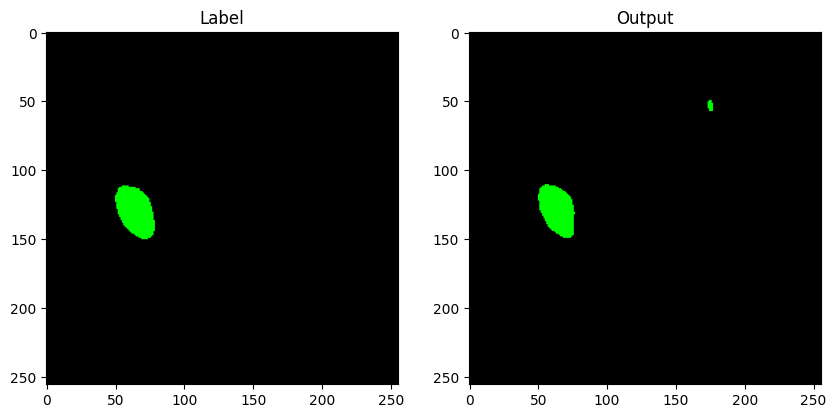

Epoch [145/180], Loss: 0.1630161621


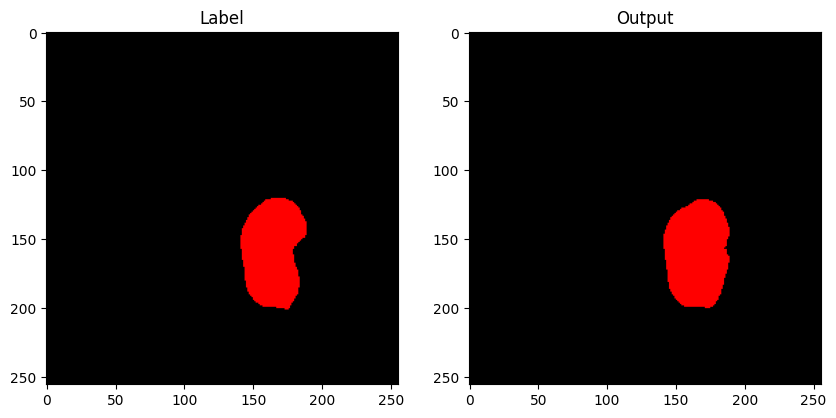

Epoch [146/180], Loss: 0.1467885881


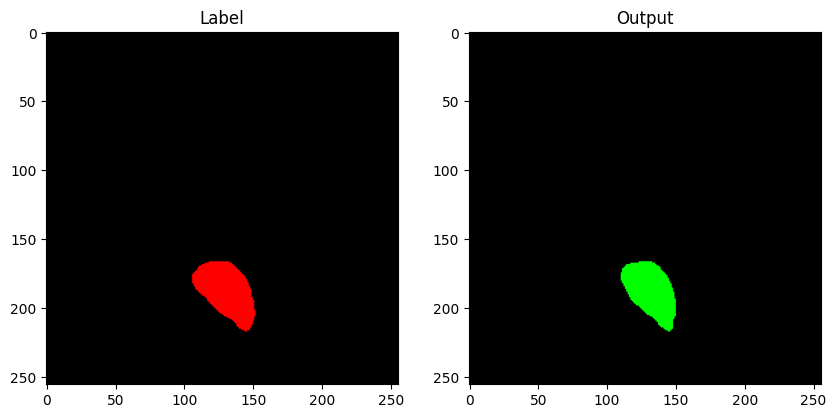

Epoch [147/180], Loss: 0.1535092972


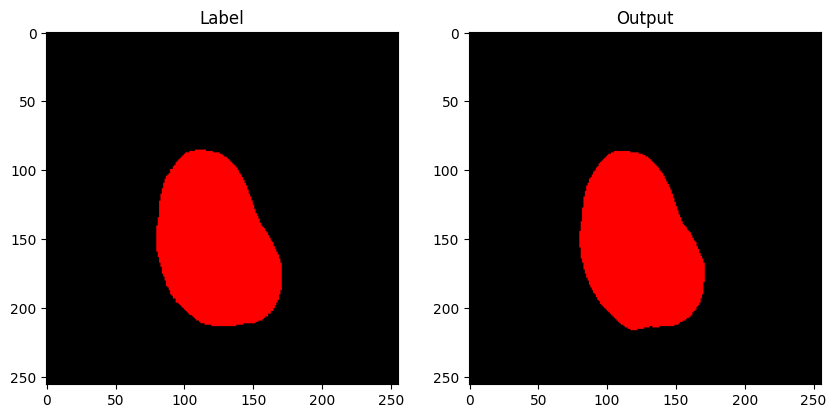

Epoch [148/180], Loss: 0.1431426417


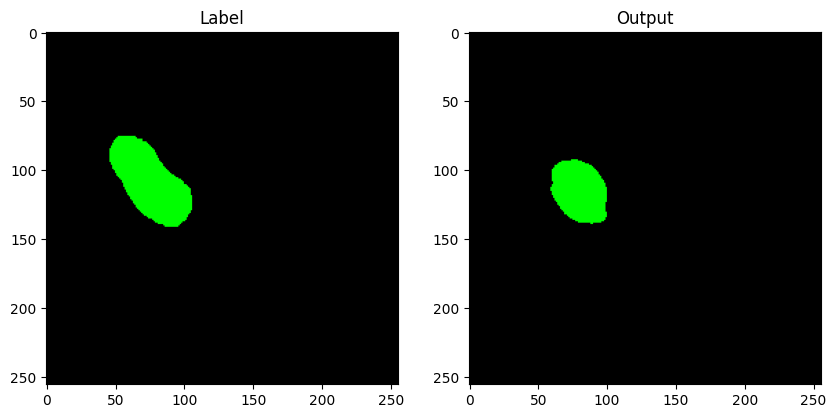

Epoch [149/180], Loss: 0.1329693198


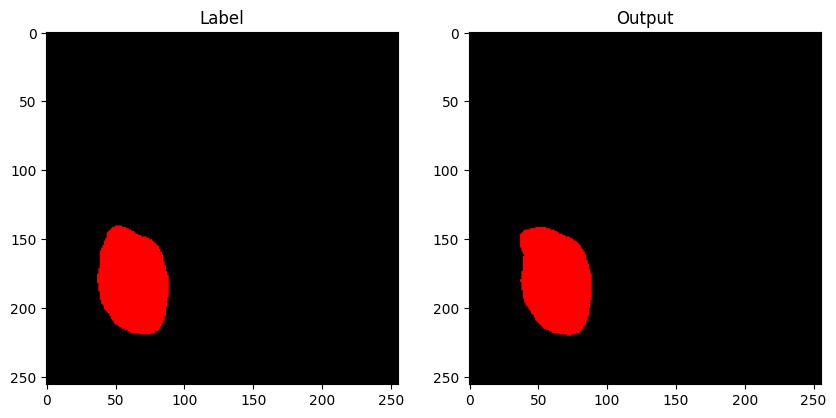

Epoch [150/180], Loss: 0.1464861816


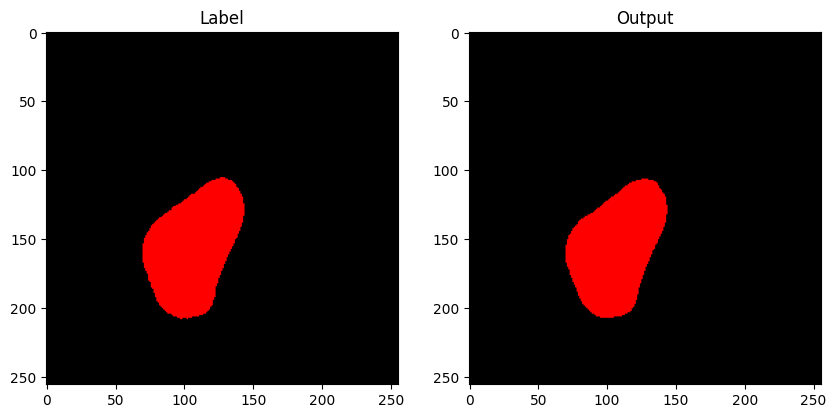

Epoch [151/180], Loss: 0.1438265738


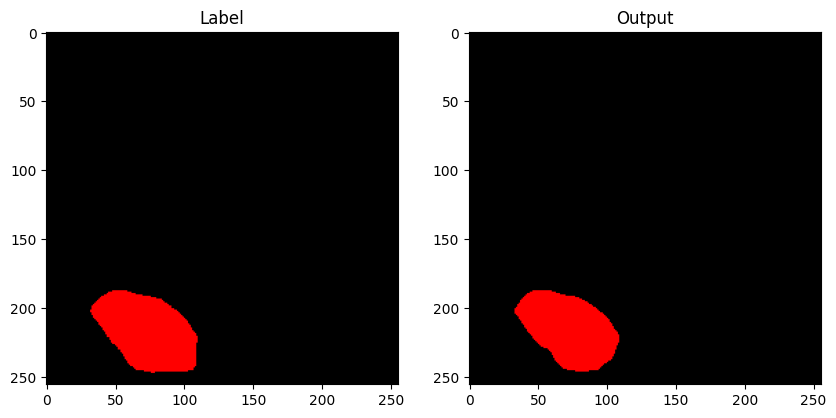

Epoch [152/180], Loss: 0.1303453623


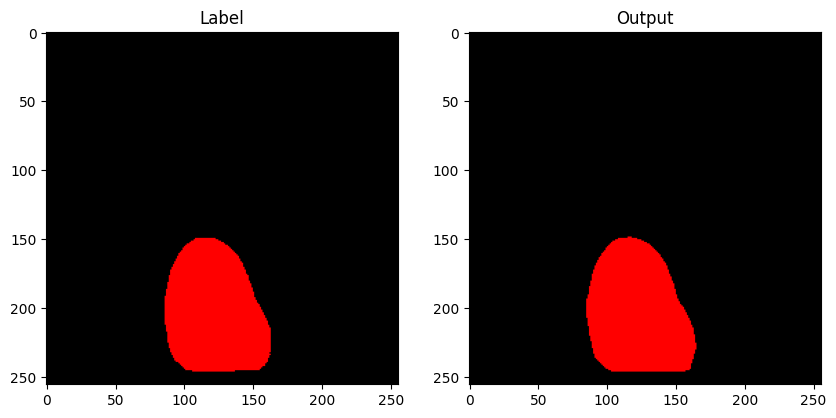

Epoch [153/180], Loss: 0.1346165339


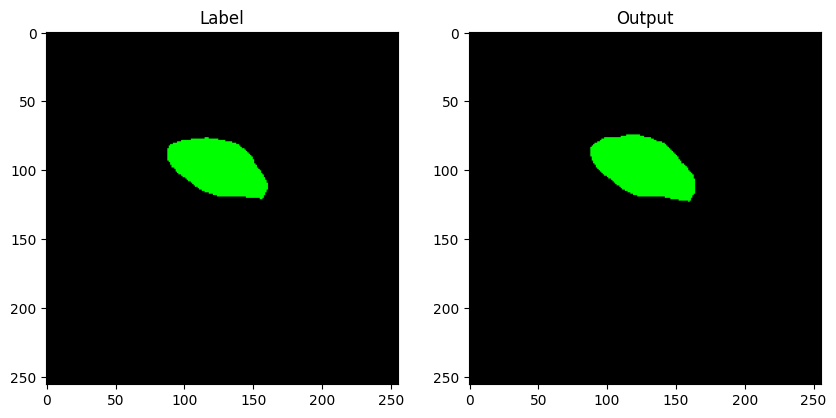

Epoch [154/180], Loss: 0.1403290970


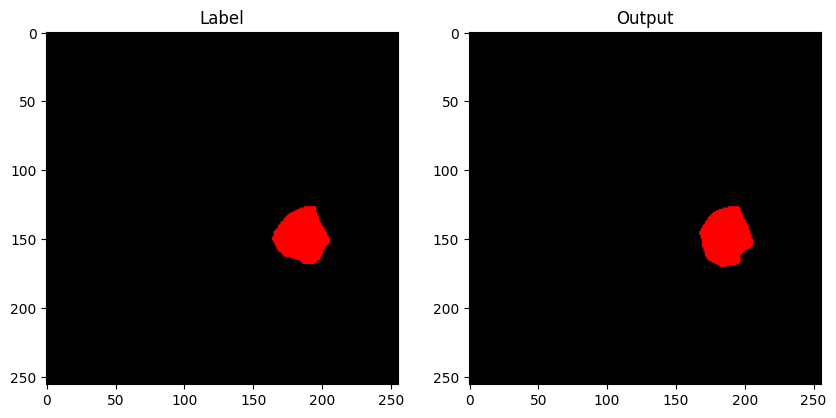

Epoch [155/180], Loss: 0.1114560164


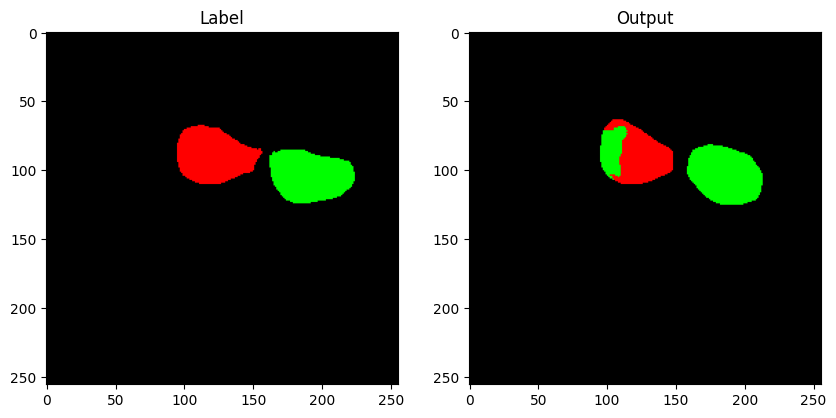

Epoch [156/180], Loss: 0.1311032468


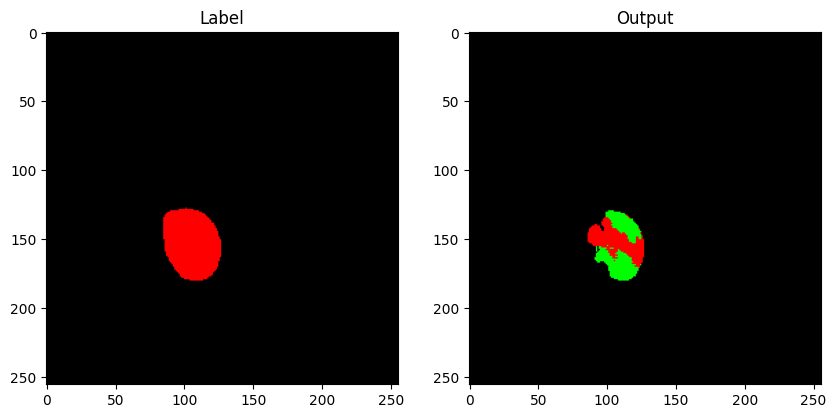

Epoch [157/180], Loss: 0.1354455859


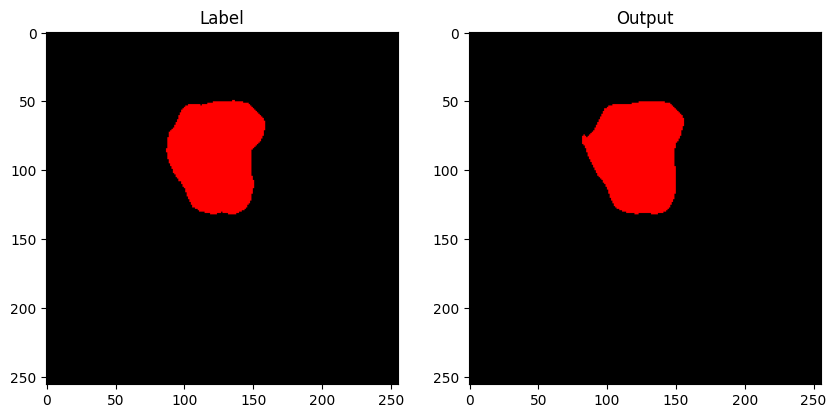

Epoch [158/180], Loss: 0.1297864375


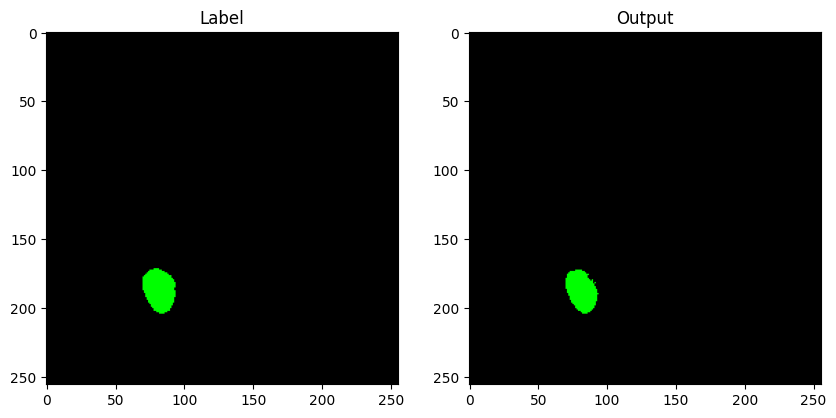

Epoch [159/180], Loss: 0.1249480629


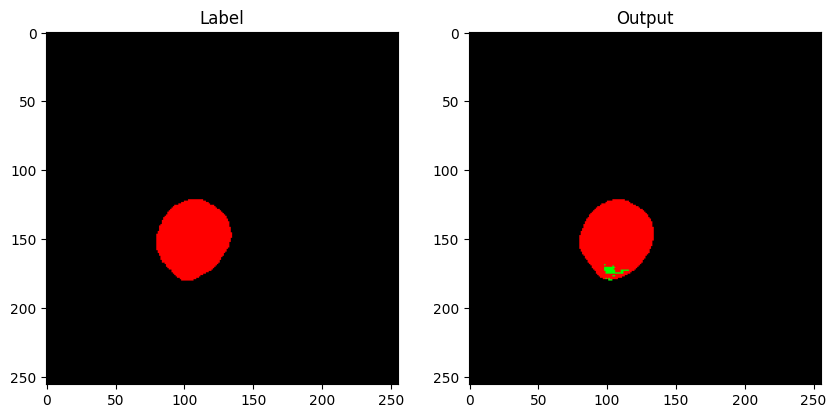

Epoch [160/180], Loss: 0.1319303435


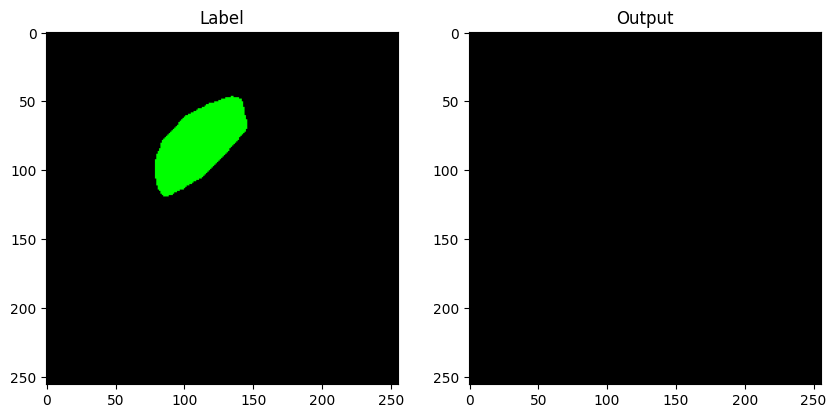

Epoch [161/180], Loss: 0.1150400563


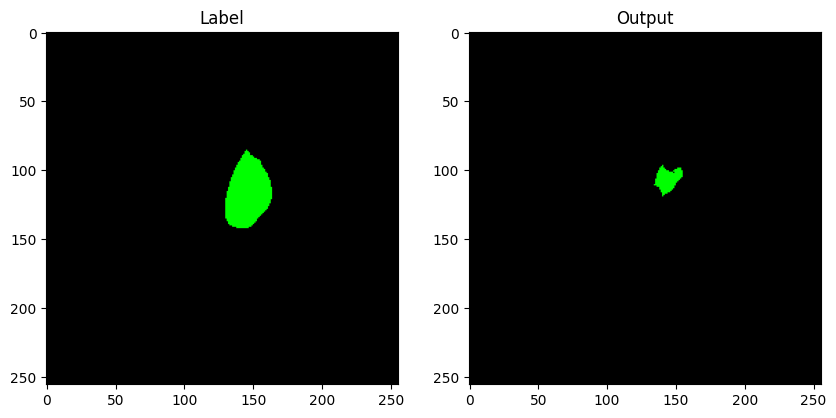

Epoch [162/180], Loss: 0.1287823271


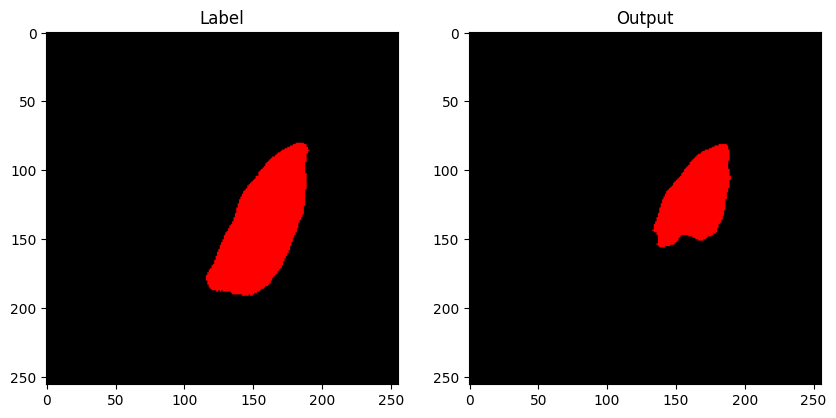

Epoch [163/180], Loss: 0.1232345578


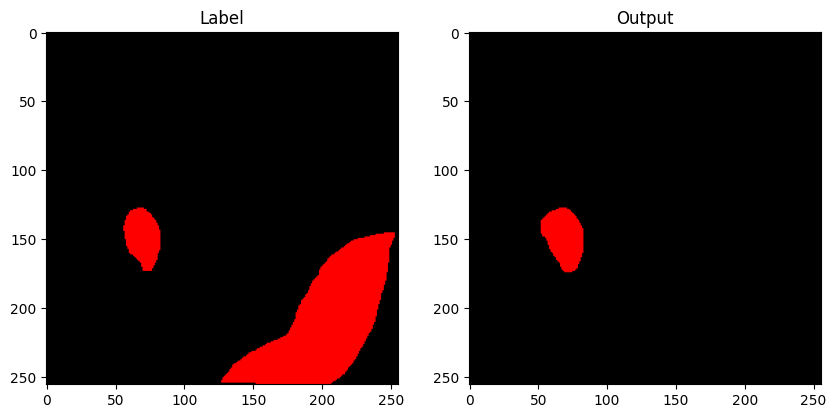

Epoch [164/180], Loss: 0.1251688730


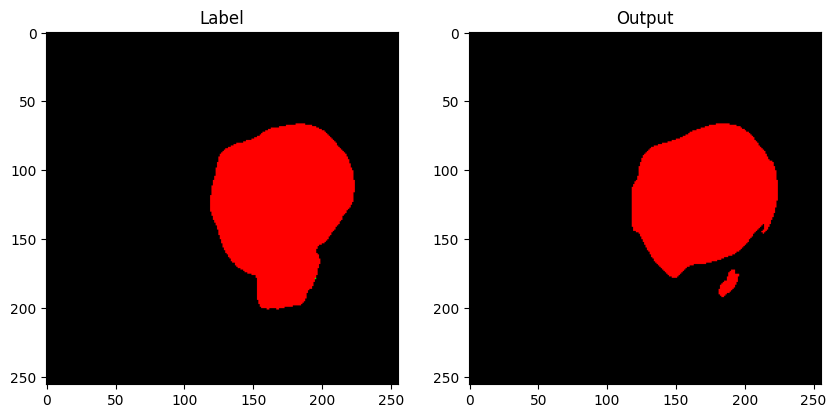

Epoch [165/180], Loss: 0.1334445740


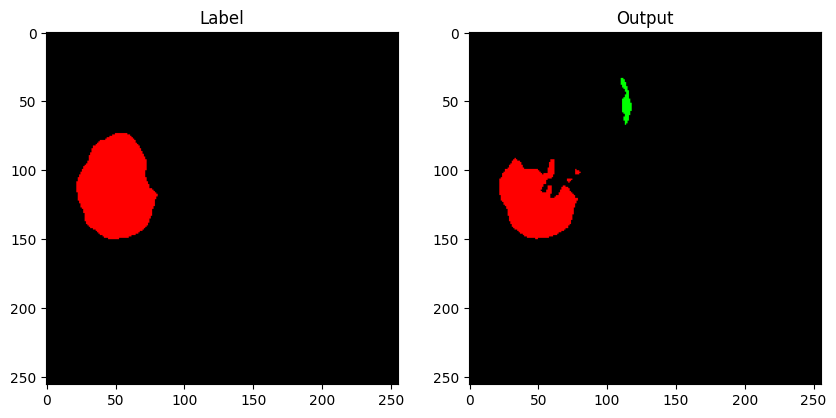

Epoch [166/180], Loss: 0.1196177013


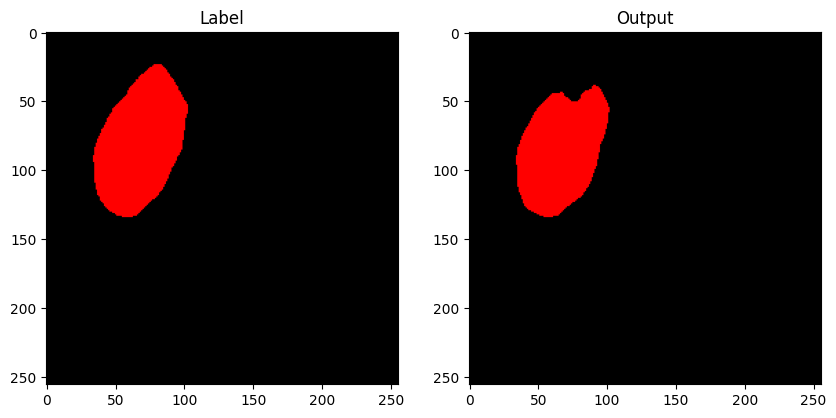

Epoch [167/180], Loss: 0.1232253594


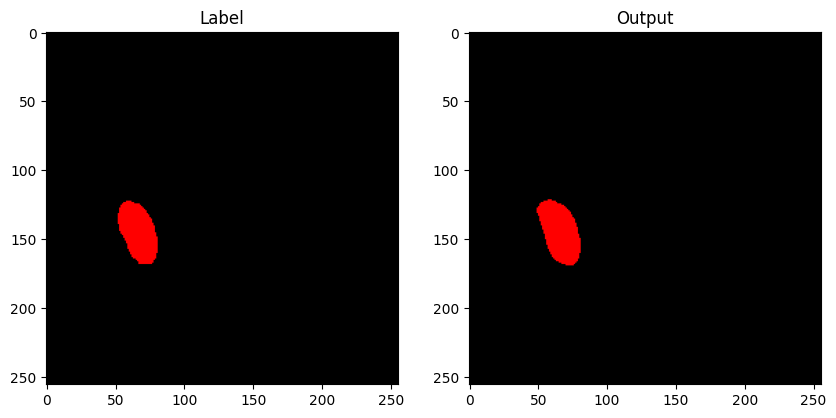

Epoch [168/180], Loss: 0.1260852493


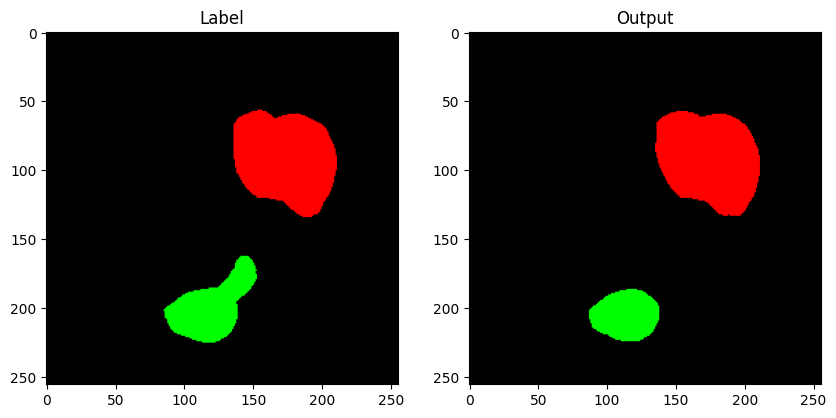

Epoch [169/180], Loss: 0.1825259110


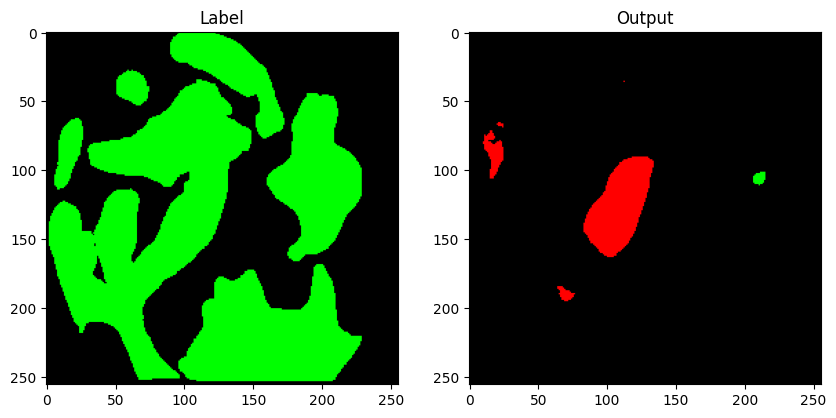

Epoch [170/180], Loss: 0.1261093694


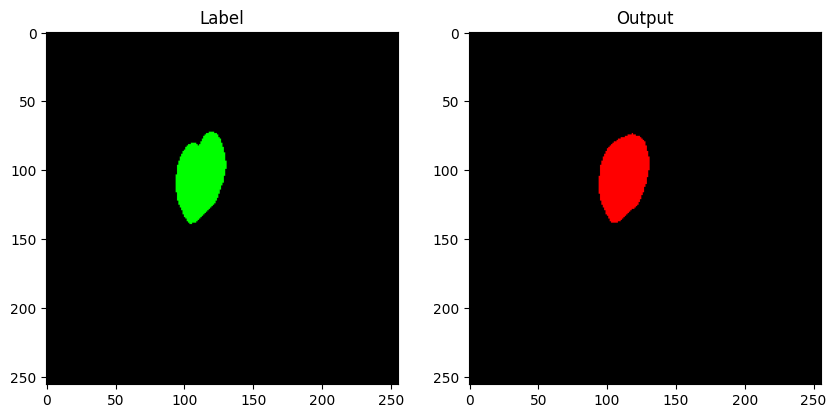

Epoch [171/180], Loss: 0.1287614279


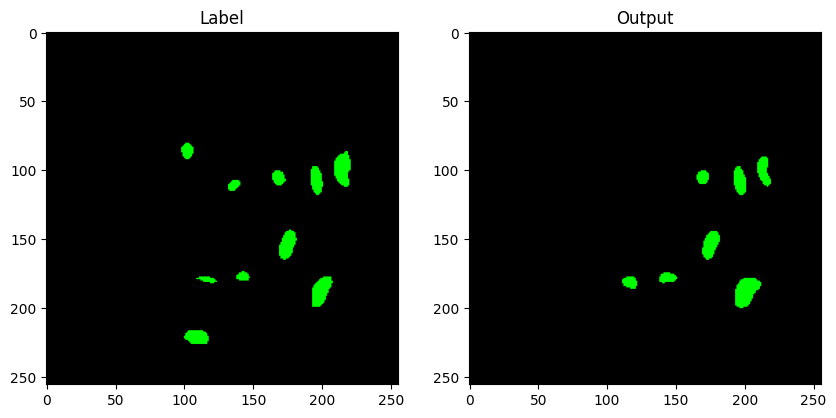

Epoch [172/180], Loss: 0.1380960476


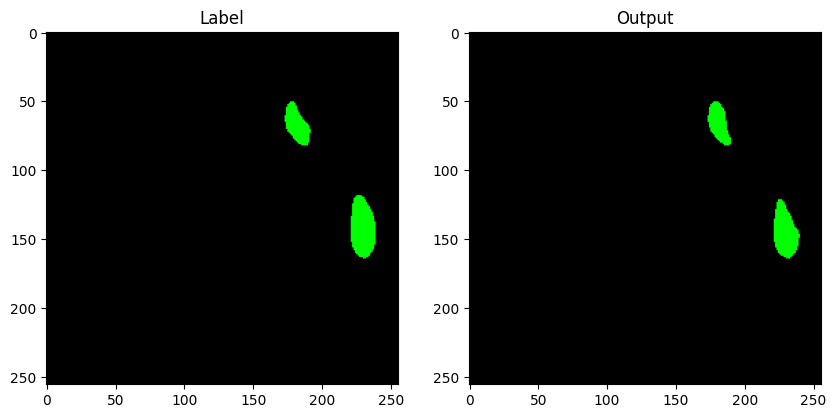

Epoch [173/180], Loss: 0.1351899025


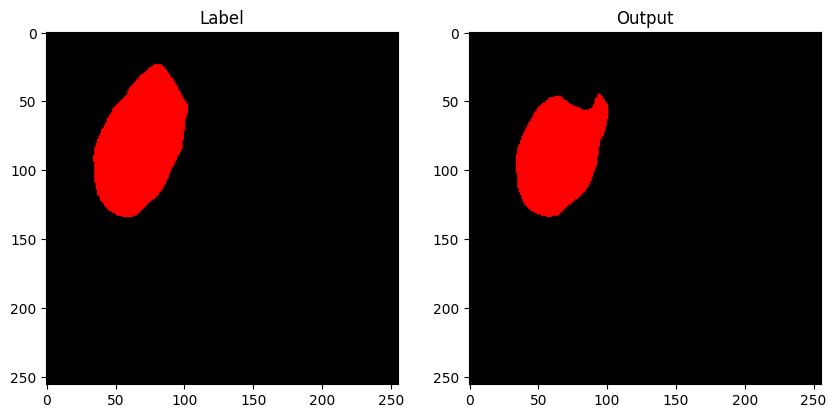

Epoch [174/180], Loss: 0.1362205775


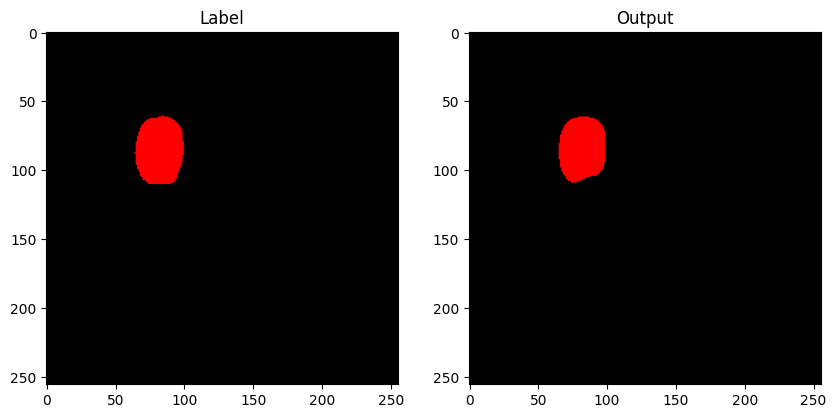

Epoch [175/180], Loss: 0.1382958400


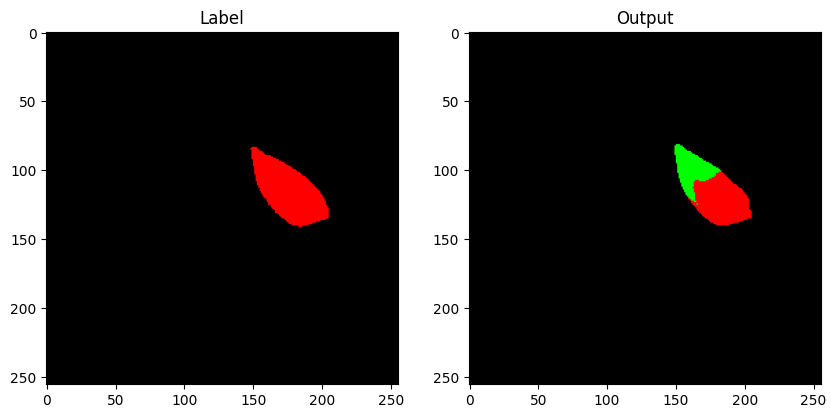

Epoch [176/180], Loss: 0.1406971512


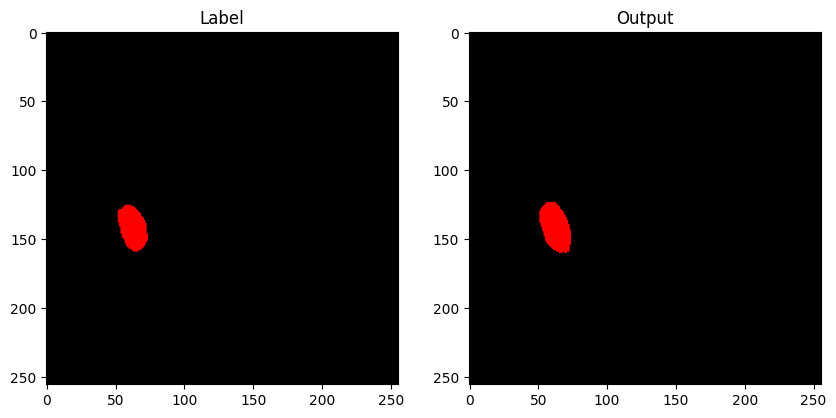

Epoch [177/180], Loss: 0.1444624646


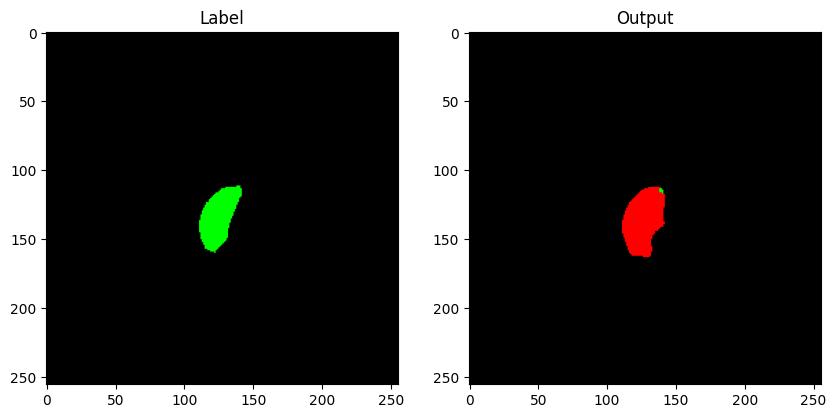

Epoch [178/180], Loss: 0.1390883346


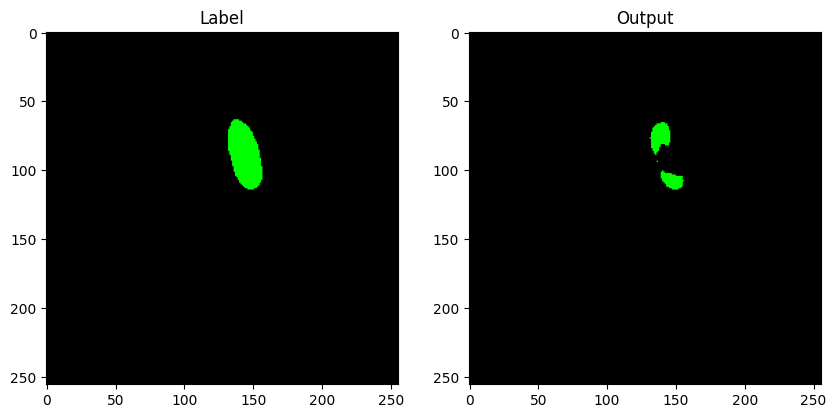

Epoch [179/180], Loss: 0.1466387784


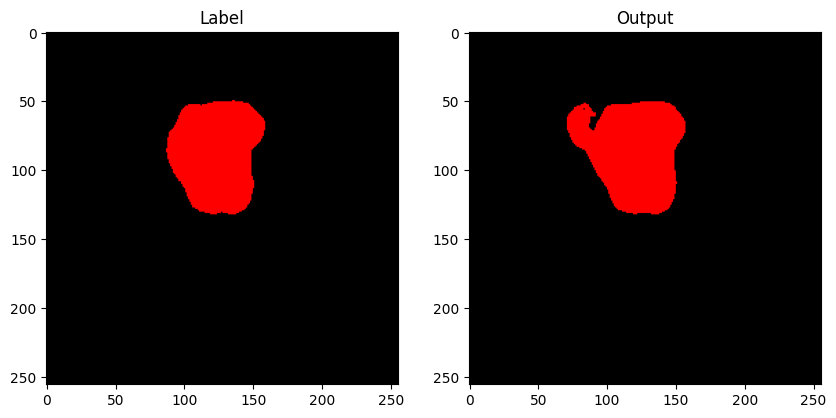

Epoch [180/180], Loss: 0.1460014815


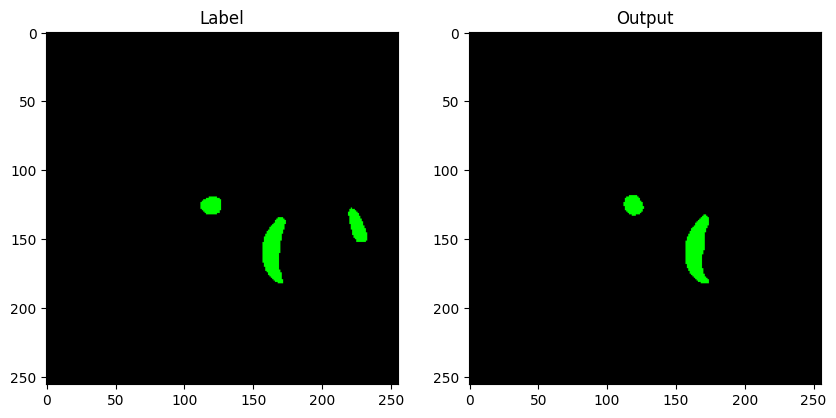

In [19]:
num_epochs = 180

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
best_val_loss = 999

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        labels = labels.squeeze(dim=1).long()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(dim=1).long()

            outputs = model(images)

            val_loss += criterion(outputs.float(),labels.long()).item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss/len(val_loader):.10f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': val_loss,
        }
        save_path = f'colorization_model.pth'
        torch.save(checkpoint, save_path)
        print('Save new model')
    wandb.log({'Val_loss': val_loss/len(val_loader),
               'Train_loss': train_loss/len(train_loader)
              })

    label = labels[0].cpu().numpy()
    label = mask_to_rgb(label,color_dict)
    outputs[0] = outputs[0].softmax(dim=0)
    output = outputs[0].cpu().numpy()
    output = np.argmax(output, axis=0)
    output = mask_to_rgb(output,color_dict)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(label)
    axs[0].set_title('Label')
    axs[1].imshow(output)
    axs[1].set_title('Output')
    plt.show()

In [20]:
checkpoint = torch.load('colorization_model.pth')
model.load_state_dict(checkpoint['model'])
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

<ipython-input-20-f5ce3d5dffc9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('colorization_model.pth')


UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [21]:
!mkdir prediction

In [22]:
trainsize = 256
model.eval()
for i in os.listdir("/content/test/test"):
    img_path = os.path.join("/content/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (trainsize, trainsize))
    transformed = val_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    mask_rgb = mask_to_rgb(mask, color_dict)
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite("prediction/{}".format(i), mask_rgb)

In [23]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]

    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/content/prediction'
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)
print('Done')

/content/prediction/94a7f32574d6c748c41743c6c08a1d1a.jpeg
/content/prediction/30c2f4fc276ed9f178dc2f4af6266509.jpeg
/content/prediction/e9082ea2c193ac8d551c149b60f29653.jpeg
/content/prediction/39dda50f954ba59c7de13a35276a4764.jpeg
/content/prediction/395e56a6d9ba9d45c3dbc695325ded46.jpeg
/content/prediction/782707d7c359e27888daefee82519763.jpeg
/content/prediction/67d4dcf9596154efb7cef748d9cbd617.jpeg
/content/prediction/1002ec4a1fe748f3085f1ce88cbdf366.jpeg
/content/prediction/314fe384eb2ba3adfda6c1899fdc9837.jpeg
/content/prediction/ca4d5060a633a8d5b2b2b55157b7781e.jpeg
/content/prediction/6f4d4987ea3b4bae5672a230194c5a08.jpeg
/content/prediction/5beb48f0be11d0309d1dff09b8405734.jpeg
/content/prediction/4baddc22268d4b4ef4d95ceea1195799.jpeg
/content/prediction/1531871f2fd85a04faeeb2b535797395.jpeg
/content/prediction/6b83ef461c2a337948a41964c1d4f50a.jpeg
/content/prediction/3c3ca4d5060a633a8d5b2b2b55157b77.jpeg
/content/prediction/c41545ba55aadaa77712a48e11d579d9.jpeg
/content/predi

In [24]:
!ls /content


bkai-igh-neopolyp.zip	output.csv  sample_data		   test   train_gt
colorization_model.pth	prediction  sample_submission.csv  train  wandb


In [25]:
from google.colab import files
files.download('/content/output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>